# Isolation Forest Benchmarking

This notebook contains timing analysis comparing:
1. **Single Tree vs Ensemble**: Performance impact of ensemble size
2. **Sequential vs Parallel**: Speedup from parallelization
3. **sklearn Baseline**: Comparison with scikit-learn's implementation
4. **pyod Comparison**: Benchmarking against pyod's isolation forest
5. **Summary Table**: Consolidated results
6. **Rank Difference**: Performance ranking across implementations
7. **Prediction Time**: Evaluation of prediction latency
8. **Large Dataset Scaling**: Performance on large datasets
9. **Prediction accuracy**: Accuracy comparison across implementations

All tests use multiple runs for statistical validity and report mean $\pm$ std dev.

## Setup and Imports

In [1]:
import os
import sys

sys.path.insert(0, os.path.join(os.path.dirname(os.getcwd())))

import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import spearmanr, kendalltau

from typing import Callable, Any
from sklearn.datasets import make_moons, make_circles
from sklearn.ensemble import IsolationForest as SklearnIsolationForest

from src.isolation.tree import IsolationTree
from src.isolation.forest import IsolationForest
from src.kmeans_isolation.tree import KMeansIsolationTree
from src.kmeans_isolation.forest import KMeansIsolationForest

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("All imports successful \u2705")

All imports successful ✅


## Utility Functions

In [2]:
def time_execution(
    func: Callable, 
    n_runs: int = 5, 
    *args, **kwargs
) -> tuple[float, float]:
    """Time function execution over multiple runs.
    Args:
        func: Function to time
        n_runs: Number of runs for averaging
        *args, **kwargs: Arguments to pass to func
    Returns:
        (mean_time, std_time) in seconds
    """
    times = []
    for _ in range(n_runs):
        start = time.perf_counter()
        func(*args, **kwargs)
        end = time.perf_counter()
        times.append(end - start)
    return np.float64(np.mean(times)), np.float64(np.std(times))


def generate_rectangles_dataset(
    n_normal: int = 900, 
    n_anomalies: int = 100, 
    seed: int = 42
):
    """Generate 9 rectangles in a 3x3 grid dataset with anomalies."""
    np.random.seed(seed)
    rectangles = []
    for i in range(3):
        for j in range(3):
            Xs_rectangle = np.random.uniform(
                low=[i * 3.0, j * 3.0],
                high=[i * 3.0 + 2.0, j * 3.0 + 2.0],
                size=(n_normal // 9, 2)
            )
            rectangles.append(Xs_rectangle)
    Xs_normal = np.vstack(rectangles)
    
    # Anomalies scattered randomly
    Xs_anomalies = np.random.uniform(
        low=[0.0, 0.0],
        high=[9.0, 9.0],
        size=(n_anomalies, 2)
    )
    
    X = np.vstack([Xs_normal, Xs_anomalies])
    y = np.array([0] * len(Xs_normal) + [1] * len(Xs_anomalies))
    return X.astype(np.float64), y


def generate_moons_dataset(
    n_normal: int = 900, 
    n_anomalies: int = 100, 
    seed: int = 42
):
    """Generate moons dataset with anomalies."""
    np.random.seed(seed)
    
    Xs_normal, _ = make_moons(n_samples=n_normal, noise=0.05, random_state=seed)
    
    Xs_anomalies = np.random.uniform(
        low=[Xs_normal[:, 0].min() - 0.5, Xs_normal[:, 1].min() - 0.5],
        high=[Xs_normal[:, 0].max() + 0.5, Xs_normal[:, 1].max() + 0.5],
        size=(n_anomalies, 2)
    )
    
    X = np.vstack([Xs_normal, Xs_anomalies])
    y = np.array([0] * len(Xs_normal) + [1] * len(Xs_anomalies))
    return X.astype(np.float64), y


def generate_circles_dataset(
    n_normal: int = 900, 
    n_anomalies: int = 100,
    seed: int = 42
):
    """Generate circles dataset with anomalies."""
    np.random.seed(seed)
    
    Xs_normal, _ = make_circles(n_samples=n_normal, noise=0.0, random_state=seed)
    
    Xs_anomalies = np.random.uniform(
        low=[Xs_normal[:, 0].min() - 0.5, Xs_normal[:, 1].min() - 0.5],
        high=[Xs_normal[:, 0].max() + 0.5, Xs_normal[:, 1].max() + 0.5],
        size=(n_anomalies, 2)
    )
    
    X = np.vstack([Xs_normal, Xs_anomalies])
    y = np.array([0] * len(Xs_normal) + [1] * len(Xs_anomalies))
    return X.astype(np.float64), y


def generate_synthetic_dataset(
    n_samples: int, 
    n_features: int, 
    contamination: float = 0.1, 
    seed: int = 42
):
    """Generate synthetic high-dimensional dataset."""
    np.random.seed(seed)
    
    n_normal = int(n_samples * (1 - contamination))
    n_anomalies = n_samples - n_normal
    
    # Normal samples from standard normal
    X_normal = np.random.randn(n_normal, n_features)
    
    # Anomalies from shifted/scaled distribution
    X_anomalies = np.random.randn(n_anomalies, n_features) * 3 + 5
    
    X = np.vstack([X_normal, X_anomalies])
    y = np.array([0] * n_normal + [1] * n_anomalies)
    
    indices = np.arange(len(X))
    np.random.shuffle(indices)
    
    return X[indices].astype(np.float64), y[indices]


print("Utility functions defined \u2705")

Utility functions defined ✅


## Section 1: Single Tree vs Ensemble Timing

Compare the performance of single isolation trees vs full ensembles for both standard and K-Means variants.

In [11]:
print("-" * 80)
print("Single Tree vs Ensemble Performance")
print("-" * 80)

# Configuration
n_runs = 5
ensemble_size = 100
subsample_size = 256
dataset_sizes = [500, 800, 900, 1000, 5000]

results_tree_vs_ensemble = []

for n_samples in dataset_sizes:
    print(f"\n{'Testing Dataset size:':<30} {n_samples:,} samples")
    
    X, y = generate_synthetic_dataset(n_samples, n_features=5, seed=42)
    
    # 1. Standard IsolationTree (single)
    def train_single_tree():
        tree = IsolationTree()
        tree.fit(X, subsample_size=subsample_size, contamination=0.1)
        
    mean_time, std_time = time_execution(train_single_tree, n_runs=n_runs)

    print(f"{'IsolationTree (single):':<28} {mean_time:.4f} \u00B1 {std_time:.4f} sec")
    results_tree_vs_ensemble.append({
        'Dataset Size': n_samples,
        'Method': 'IsolationTree (single)',
        'Mean Time (s)': mean_time,
        'Std Time (s)': std_time
    })
    
    # 2. Standard IsolationForest (ensemble)
    def train_forest():
        forest = IsolationForest(ensemble_size=ensemble_size, n_jobs=1, random_state=42)
        forest.fit(X, subsample_size=subsample_size, contamination=0.1)
    
    mean_time, std_time = time_execution(train_forest, n_runs=n_runs)

    print(f"{f'IsolationForest (n={ensemble_size}):':<28} {mean_time:.4f} \u00B1 {std_time:.4f} sec")
    results_tree_vs_ensemble.append({
        'Dataset Size': n_samples,
        'Method': f'IsolationForest (n={ensemble_size})',
        'Mean Time (s)': mean_time,
        'Std Time (s)': std_time
    })
    
    # 3. K-Means IsolationTree (single)
    def train_single_kmeans_tree():
        tree = KMeansIsolationTree()
        tree.fit(X, subsample_size=subsample_size, contamination=0.1)
    
    mean_time, std_time = time_execution(train_single_kmeans_tree, n_runs=n_runs)

    print(f"{'KMeansIsolationTree (single):':<28} {mean_time:.4f} \u00B1 {std_time:.4f} sec")
    results_tree_vs_ensemble.append({
        'Dataset Size': n_samples,
        'Method': 'KMeansIsolationTree (single)',
        'Mean Time (s)': mean_time,
        'Std Time (s)': std_time
    })
    
    # 4. K-Means IsolationForest (ensemble)
    def train_kmeans_forest():
        forest = KMeansIsolationForest(ensemble_size=ensemble_size, n_jobs=1, random_state=42)
        forest.fit(X, subsample_size=subsample_size, contamination=0.1)
    
    mean_time, std_time = time_execution(train_kmeans_forest, n_runs=n_runs)

    print(f"{f'KMeansIsolationForest (n={ensemble_size}):':<28} {mean_time:.4f} \u00B1 {std_time:.4f} sec")
    results_tree_vs_ensemble.append({
        'Dataset Size': n_samples,
        'Method': f'KMeansIsolationForest (n={ensemble_size})',
        'Mean Time (s)': mean_time,
        'Std Time (s)': std_time
    })

# Create DataFrame
df_tree_vs_ensemble = pd.DataFrame(results_tree_vs_ensemble)

print("\n" + "-" * 80)
print("Summary:")
print("-" * 80)
print(df_tree_vs_ensemble.to_string(index=False))

# Save results
os.makedirs('../results/timing', exist_ok=True)

df_tree_vs_ensemble.to_csv('../results/timing/tree_vs_ensemble.csv', index=False)

print("\nResults saved to results/timing/tree_vs_ensemble.csv \u2705")

--------------------------------------------------------------------------------
Single Tree vs Ensemble Performance
--------------------------------------------------------------------------------

Testing Dataset size:          500 samples
IsolationTree (single):      0.0014 ± 0.0003 sec
IsolationForest (n=100):     0.3000 ± 0.1822 sec
KMeansIsolationTree (single): 0.4123 ± 0.0175 sec
KMeansIsolationForest (n=100): 44.0990 ± 1.2233 sec

Testing Dataset size:          800 samples
IsolationTree (single):      0.0012 ± 0.0003 sec
IsolationForest (n=100):     0.1984 ± 0.0859 sec
KMeansIsolationTree (single): 0.4240 ± 0.0131 sec
KMeansIsolationForest (n=100): 44.0078 ± 0.3982 sec

Testing Dataset size:          900 samples
IsolationTree (single):      0.0017 ± 0.0005 sec
IsolationForest (n=100):     0.2742 ± 0.1329 sec
KMeansIsolationTree (single): 0.4394 ± 0.0167 sec
KMeansIsolationForest (n=100): 44.1332 ± 1.1447 sec

Testing Dataset size:          1,000 samples
IsolationTree (single): 

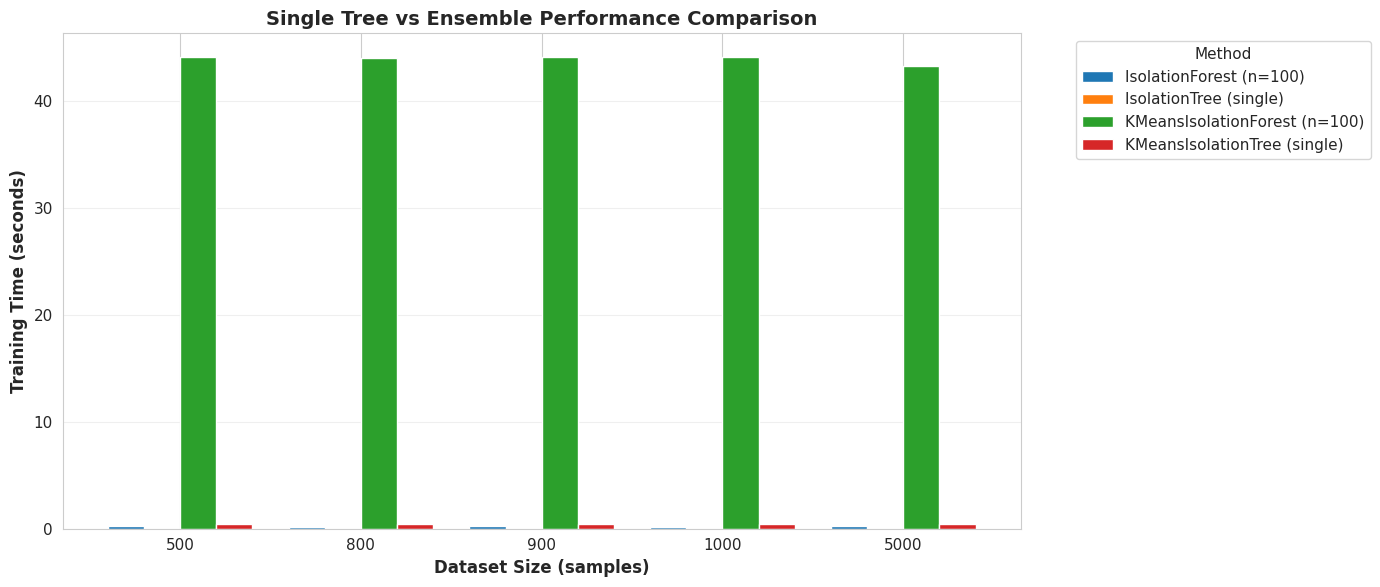

Plot saved to results/timing/tree_vs_ensemble.png ✅


In [12]:
fig, ax = plt.subplots(figsize=(14, 6))

# Pivot data for grouped bar chart
pivot_df = df_tree_vs_ensemble.pivot(index='Dataset Size', columns='Method', values='Mean Time (s)')
pivot_df.plot(kind='bar', ax=ax, width=0.8)

ax.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Single Tree vs Ensemble Performance Comparison', fontsize=14, fontweight='bold')
ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(axis='y', alpha=0.3)

plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig('../results/timing/tree_vs_ensemble.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to results/timing/tree_vs_ensemble.png \u2705")

## Section 2: Sequential vs Parallel Timing

Measure the speedup achieved by parallelization (n_jobs=$1$ vs n_jobs=$-1$).

In [13]:
print("-" * 80)
print("Sequential vs Parallel Performance")
print("-" * 80)

# Configuration
n_runs = 5
ensemble_size = 100
subsample_size = 256
dataset_sizes = [500, 800, 900, 1000, 5000]

results_parallel = []

for n_samples in dataset_sizes:
    print(f"\n{'Testing dataset size:':<30} {n_samples:,} samples")
    
    X, y = generate_synthetic_dataset(n_samples, n_features=10, seed=42)
    
    # 1. IsolationForest Sequential (n_jobs=1)
    def train_forest_seq():
        forest = IsolationForest(ensemble_size=ensemble_size, n_jobs=1, random_state=42)
        forest.fit(X, subsample_size=subsample_size, contamination=0.1)
    
    mean_time_seq, std_time_seq = time_execution(train_forest_seq, n_runs=n_runs)

    print(f"  {'IsolationForest (n_jobs=1):':<30} {mean_time_seq:.4f} ± {std_time_seq:.4f} sec")
    
    # 2. IsolationForest Parallel (n_jobs=-1)
    def train_forest_par():
        forest = IsolationForest(ensemble_size=ensemble_size, n_jobs=-1, random_state=42)
        forest.fit(X, subsample_size=subsample_size, contamination=0.1)
    
    mean_time_par, std_time_par = time_execution(train_forest_par, n_runs=n_runs)

    speedup_if = mean_time_seq / mean_time_par

    print(f"  {'IsolationForest (n_jobs=-1):':<30} {mean_time_par:.4f} ± {std_time_par:.4f} sec (speedup: {speedup_if:.2f}x)")
    
    results_parallel.append({
        'Dataset Size': n_samples,
        'Method': 'IsolationForest',
        'Sequential Time (s)': mean_time_seq,
        'Parallel Time (s)': mean_time_par,
        'Speedup': speedup_if
    })
    
    # 3. KMeansIsolationForest Sequential (n_jobs=1)
    def train_kmeans_forest_seq():
        forest = KMeansIsolationForest(ensemble_size=ensemble_size, n_jobs=1, random_state=42)
        forest.fit(X, subsample_size=subsample_size, contamination=0.1)
    
    mean_time_seq, std_time_seq = time_execution(train_kmeans_forest_seq, n_runs=n_runs)

    print(f"  {'KMeansIsolationForest (n_jobs=1):':<30} {mean_time_seq:.4f} ± {std_time_seq:.4f} sec")
    
    # 4. KMeansIsolationForest Parallel (n_jobs=-1)
    def train_kmeans_forest_par():
        forest = KMeansIsolationForest(ensemble_size=ensemble_size, n_jobs=-1, random_state=42)
        forest.fit(X, subsample_size=subsample_size, contamination=0.1)
    
    mean_time_par, std_time_par = time_execution(train_kmeans_forest_par, n_runs=n_runs)

    speedup_kmif = mean_time_seq / mean_time_par

    print(f"  {'KMeansIsolationForest (n_jobs=-1):':<30} {mean_time_par:.4f} ± {std_time_par:.4f} sec (speedup: {speedup_kmif:.2f}x)")
    
    results_parallel.append({
        'Dataset Size': n_samples,
        'Method': 'KMeansIsolationForest',
        'Sequential Time (s)': mean_time_seq,
        'Parallel Time (s)': mean_time_par,
        'Speedup': speedup_kmif
    })

# Create DataFrame
df_parallel = pd.DataFrame(results_parallel)

print("\n" + "-" * 80)
print("Summary Table:")
print("-" * 80)
print(df_parallel.to_string(index=False))

# Save results
df_parallel.to_csv('../results/timing/sequential_vs_parallel.csv', index=False)

print("\nResults saved to results/timing/sequential_vs_parallel.csv \u2705")

--------------------------------------------------------------------------------
Sequential vs Parallel Performance
--------------------------------------------------------------------------------

Testing dataset size:          500 samples
  IsolationForest (n_jobs=1):    0.3509 ± 0.1283 sec
  IsolationForest (n_jobs=-1):   0.6631 ± 0.7455 sec (speedup: 0.53x)
  KMeansIsolationForest (n_jobs=1): 43.2317 ± 0.6603 sec
  KMeansIsolationForest (n_jobs=-1): 4.3587 ± 0.1954 sec (speedup: 9.92x)

Testing dataset size:          800 samples
  IsolationForest (n_jobs=1):    0.3061 ± 0.1055 sec
  IsolationForest (n_jobs=-1):   0.2689 ± 0.1116 sec (speedup: 1.14x)
  KMeansIsolationForest (n_jobs=1): 43.4853 ± 0.8098 sec
  KMeansIsolationForest (n_jobs=-1): 4.4019 ± 0.1744 sec (speedup: 9.88x)

Testing dataset size:          900 samples
  IsolationForest (n_jobs=1):    0.2788 ± 0.1127 sec
  IsolationForest (n_jobs=-1):   0.3289 ± 0.1028 sec (speedup: 0.85x)
  KMeansIsolationForest (n_jobs=1): 43.7

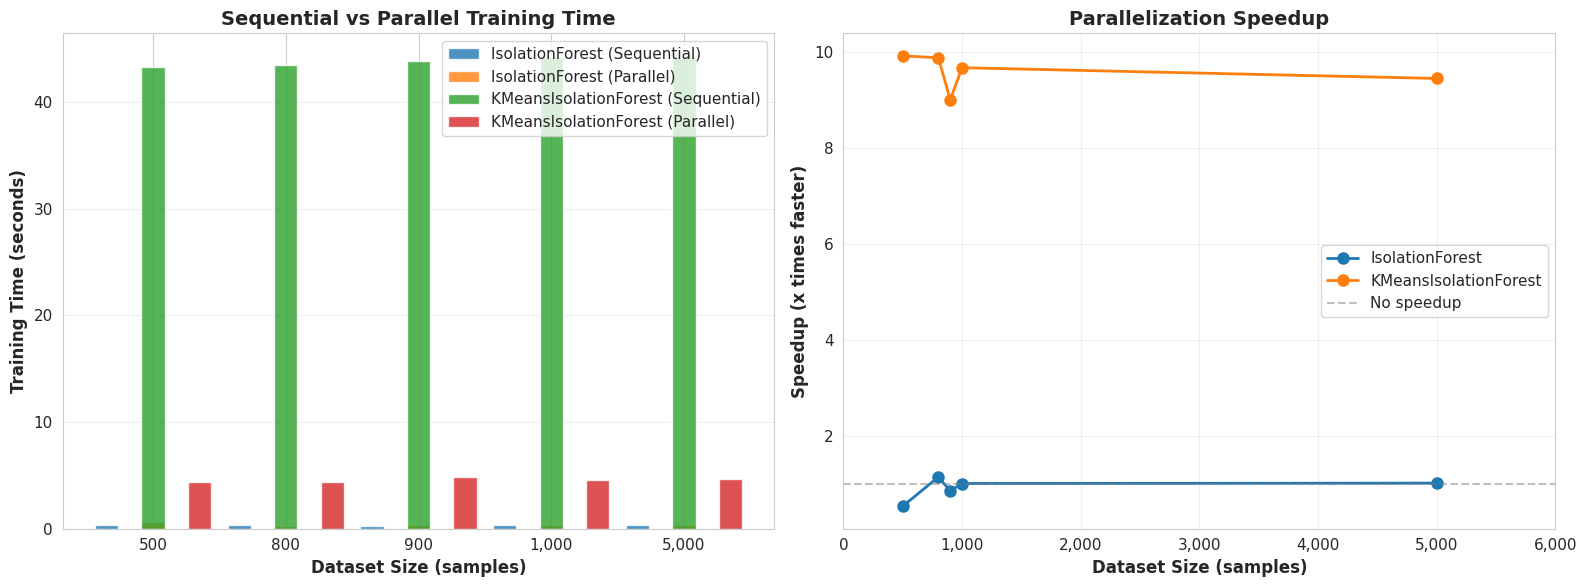

Plot saved to results/timing/sequential_vs_parallel.png ✅


In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Left: Time comparison
width = 0.35
x = np.arange(len(dataset_sizes))

for i, method in enumerate(['IsolationForest', 'KMeansIsolationForest']):
    method_data = df_parallel[df_parallel['Method'] == method]
    offset = width * (i - 0.5)
    
    ax1.bar(x + offset - width / 2, method_data['Sequential Time (s)'], width / 2, 
            label=f'{method} (Sequential)', alpha=0.8)

    ax1.bar(x + offset + width / 2, method_data['Parallel Time (s)'], width / 2, 
            label=f'{method} (Parallel)', alpha=0.8)

ax1.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Sequential vs Parallel Training Time', fontsize=14, fontweight='bold')

ax1.set_xticks(x)
ax1.set_xticklabels([f'{size:,}' for size in dataset_sizes])

ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Plot Right: Speedup ratio
for method in ['IsolationForest', 'KMeansIsolationForest']:
    method_data = df_parallel[df_parallel['Method'] == method]
    ax2.plot(method_data['Dataset Size'], method_data['Speedup'], 
             marker='o', linewidth=2, markersize=8, label=method)

ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='No speedup')
ax2.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Speedup (x times faster)', fontsize=12, fontweight='bold')
ax2.set_title('Parallelization Speedup', fontsize=14, fontweight='bold')

ax2.legend()
ax2.grid(alpha=0.3)

ticks = ax2.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels([f'{int(t):,}' for t in ticks])

plt.tight_layout()
plt.savefig('../results/timing/sequential_vs_parallel.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to results/timing/sequential_vs_parallel.png \u2705")

## Section 3: sklearn Comparison

Compare our IsolationForest implementation with sklearn's IsolationForest.

In [4]:
print("-" * 80)
print("Comparison with sklearn IsolationForest")
print("-" * 80)

# Configuration
n_runs = 5
ensemble_size = 100
subsample_size = 256
dataset_sizes = [1000, 5000, 10000, 20000]

results_sklearn = []

for n_samples in dataset_sizes:
    print(f"\n{'Testing dataset size:':<30} {n_samples:,} samples")
    
    X, y = generate_synthetic_dataset(n_samples, n_features=10, seed=42)
    
    # 1. Our IsolationForest (parallel)
    def train_our_forest():
        forest = IsolationForest(ensemble_size=ensemble_size, n_jobs=-1, random_state=42)
        forest.fit(X, subsample_size=subsample_size, contamination=0.1)
    
    mean_time, std_time = time_execution(train_our_forest, n_runs=n_runs)
    print(f"  {'Our IsolationForest:':<30} {mean_time:.4f} ± {std_time:.4f} sec")
    results_sklearn.append({
        'Dataset Size': n_samples,
        'Method': 'Our IsolationForest',
        'Mean Time (s)': mean_time,
        'Std Time (s)': std_time
    })
    
    # 2. sklearn IsolationForest
    def train_sklearn_forest():
        forest = SklearnIsolationForest(
            n_estimators=ensemble_size, 
            max_samples=subsample_size,
            contamination=0.1,
            n_jobs=-1,
            random_state=42
        )
        forest.fit(X)
    
    mean_time, std_time = time_execution(train_sklearn_forest, n_runs=n_runs)
    print(f"  {'sklearn IsolationForest:':<30} {mean_time:.4f} ± {std_time:.4f} sec")
    results_sklearn.append({
        'Dataset Size': n_samples,
        'Method': 'sklearn IsolationForest',
        'Mean Time (s)': mean_time,
        'Std Time (s)': std_time
    })
    
    # 3. Our KMeansIsolationForest (parallel)
    def train_our_kmeans_forest():
        forest = KMeansIsolationForest(ensemble_size=ensemble_size, n_jobs=-1, random_state=42)
        forest.fit(X, subsample_size=subsample_size, contamination=0.1)
    
    mean_time, std_time = time_execution(train_our_kmeans_forest, n_runs=n_runs)
    print(f"  {'Our KMeansIsolationForest:':<30} {mean_time:.4f} ± {std_time:.4f} sec")
    results_sklearn.append({
        'Dataset Size': n_samples,
        'Method': 'Our KMeansIsolationForest',
        'Mean Time (s)': mean_time,
        'Std Time (s)': std_time
    })

# Create DataFrame
df_sklearn = pd.DataFrame(results_sklearn)

print("\n" + "-" * 80)
print("Summary Table:")
print("-" * 80)
print(df_sklearn.to_string(index=False))

# Save results
df_sklearn.to_csv('../results/timing/sklearn_comparison.csv', index=False)

print("\nResults saved to results/timing/sklearn_comparison.csv \u2705")

--------------------------------------------------------------------------------
Comparison with sklearn IsolationForest
--------------------------------------------------------------------------------

Testing dataset size:          1,000 samples
  Our IsolationForest:           0.6097 ± 0.7241 sec
  sklearn IsolationForest:       0.0793 ± 0.0059 sec
  Our KMeansIsolationForest:     3.8982 ± 0.0986 sec

Testing dataset size:          5,000 samples
  Our IsolationForest:           0.2891 ± 0.0380 sec
  sklearn IsolationForest:       0.0873 ± 0.0043 sec
  Our KMeansIsolationForest:     4.1965 ± 0.0817 sec

Testing dataset size:          10,000 samples
  Our IsolationForest:           0.3687 ± 0.0115 sec
  sklearn IsolationForest:       0.1238 ± 0.0390 sec
  Our KMeansIsolationForest:     4.5706 ± 0.1795 sec

Testing dataset size:          20,000 samples
  Our IsolationForest:           0.5551 ± 0.0519 sec
  sklearn IsolationForest:       0.1531 ± 0.0094 sec
  Our KMeansIsolationForest: 

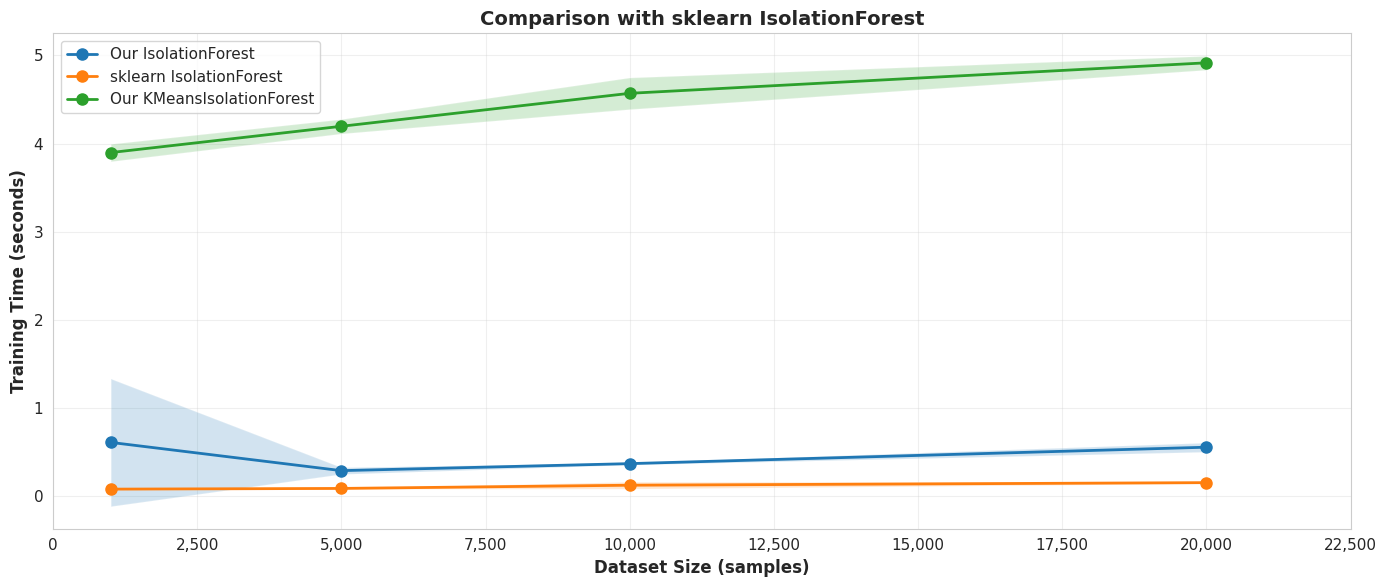

Plot saved to results/timing/sklearn_comparison.png ✅


In [5]:
fig, ax = plt.subplots(figsize=(14, 6))

for method in df_sklearn['Method'].unique():
    method_data = df_sklearn[df_sklearn['Method'] == method]
    ax.plot(method_data['Dataset Size'], method_data['Mean Time (s)'], 
            marker='o', linewidth=2, markersize=8, label=method)
    
    # Error bars
    ax.fill_between(
        method_data['Dataset Size'],
        method_data['Mean Time (s)'] - method_data['Std Time (s)'],
        method_data['Mean Time (s)'] + method_data['Std Time (s)'],
        alpha=0.2
    )

ax.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
ax.set_ylabel('Training Time (seconds)', fontsize=12, fontweight='bold')
ax.set_title('Comparison with sklearn IsolationForest', fontsize=14, fontweight='bold')

ax.legend()
ax.grid(alpha=0.3)

ticks = ax.get_xticks()
ax.set_xticks(ticks)
ax.set_xticklabels([f'{int(t):,}' for t in ticks])

plt.tight_layout()
plt.savefig('../results/timing/sklearn_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("Plot saved to results/timing/sklearn_comparison.png \u2705")

## Section 4: PyOD Library Comparison

Compare our implementations with [PyOD](https://github.com/yzhao062/pyod) - Python Outlier Detection library.

PyOD provides 45+ anomaly detection algorithms including:
- Standard Isolation Forest (optimized)
- Deep Isolation Forest (DIF) - neural network variant
- K-Means based detectors
- LOF, COPOD, ECOD, and many more

We'll benchmark:
1. PyOD IForest vs Our IsolationForest vs sklearn IsolationForest
2. PyOD K-Means detector vs Our KMeansIsolationForest

In [3]:
import pyod
from pyod.models.iforest import IForest as PyODIForest
from pyod.models.knn import KNN as PyODKNN  # K-NN based detector as alternative

### 4.1 Isolation Forest Comparison: Ours vs PyOD vs sklearn

In [4]:
print("-"*80)
print("Three-way Isolation Forest Comparison")
print("-"*80)

# Test configurations
n_estimators = 100
dataset_sizes = [1000, 5000, 10000, 50000]

results_three_way = []

print("\nComparing:")
print("  1. Our IsolationForest (parallel)")
print("  2. PyOD IForest")
print("  3. sklearn IsolationForest")

print(f"\nDataset sizes: {dataset_sizes}")
print(f"Ensemble size: {n_estimators} trees\n")

for n_samples in dataset_sizes:
    print(f"\nTesting with {n_samples} samples...")
    
    # Generate test data
    X_test = make_moons(n_samples=n_samples, noise=0.1, random_state=42)[0]
    
    # 1. Our IsolationForest
    def train_our_forest():
        forest = IsolationForest(ensemble_size=n_estimators, n_jobs=-1, random_state=42)
        forest.fit(X_test, subsample_size=256)
    
    mean_time_ours, std_time_ours = time_execution(train_our_forest, n_runs=5)
    print(f"  Our IForest:    {mean_time_ours:.4f}s ± {std_time_ours:.4f}s")
    
    # 2. PyOD IForest
    def train_pyod_forest():
        clf = PyODIForest(n_estimators=n_estimators, max_samples=256, random_state=42, n_jobs=-1)
        clf.fit(X_test)
    
    mean_time_pyod, std_time_pyod = time_execution(train_pyod_forest, n_runs=5)
    print(f"  PyOD IForest:   {mean_time_pyod:.4f}s ± {std_time_pyod:.4f}s")
    
    # 3. sklearn IForest
    def train_sklearn_forest():
        clf = SklearnIsolationForest(n_estimators=n_estimators, max_samples=256, random_state=42, n_jobs=-1)
        clf.fit(X_test)
    
    mean_time_sklearn, std_time_sklearn = time_execution(train_sklearn_forest, n_runs=5)
    print(f"  sklearn IForest: {mean_time_sklearn:.4f}s \u00B1 {std_time_sklearn:.4f}s")
    
    # Store results
    results_three_way.extend([
        {
            'Method': 'Our IForest',
            'Library': 'Custom',
            'Dataset Size': n_samples,
            'Mean Time (s)': mean_time_ours,
            'Std Time (s)': std_time_ours
        },
        {
            'Method': 'PyOD IForest',
            'Library': 'PyOD',
            'Dataset Size': n_samples,
            'Mean Time (s)': mean_time_pyod,
            'Std Time (s)': std_time_pyod
        },
        {
            'Method': 'sklearn IForest',
            'Library': 'sklearn',
            'Dataset Size': n_samples,
            'Mean Time (s)': mean_time_sklearn,
            'Std Time (s)': std_time_sklearn
        }
    ])

# Convert to DataFrame
df_three_way = pd.DataFrame(results_three_way)

print("\n" + "-"*80)
print("SUMMARY: Three-way IForest Comparison")
print("-" * 80)
print(df_three_way.to_string(index=False))

print("\n" + "-"*80)
print("SPEEDUP ANALYSIS (relative to sklearn)")
print("-"*80)

for n_samples in dataset_sizes:
    subset = df_three_way[df_three_way['Dataset Size'] == n_samples]
    sklearn_time = subset[subset['Method'] == 'sklearn IForest']['Mean Time (s)'].values[0]
    
    print(f"\n{n_samples} samples:")
    for method in ['Our IForest', 'PyOD IForest']:
        method_time = subset[subset['Method'] == method]['Mean Time (s)'].values[0]
        speedup = sklearn_time / method_time
        print(f"  {method:20s}: {speedup:5.2f}x {'faster' if speedup > 1 else 'slower'}")

# Save results
df_three_way.to_csv('../results/timing/three_way_iforest_comparison.csv', index=False)

print("\nResults saved to results/timing/three_way_iforest_comparison.csv \u2705")

--------------------------------------------------------------------------------
Three-way Isolation Forest Comparison
--------------------------------------------------------------------------------

Comparing:
  1. Our IsolationForest (parallel)
  2. PyOD IForest
  3. sklearn IsolationForest

Dataset sizes: [1000, 5000, 10000, 50000]
Ensemble size: 100 trees


Testing with 1000 samples...
  Our IForest:    0.5870s ± 0.7807s
  PyOD IForest:   0.0866s ± 0.0026s
  sklearn IForest: 0.0837s ± 0.0310s

Testing with 5000 samples...
  Our IForest:    0.2660s ± 0.0384s
  PyOD IForest:   0.1134s ± 0.0045s
  sklearn IForest: 0.0713s ± 0.0052s

Testing with 10000 samples...
  Our IForest:    0.3467s ± 0.0070s
  PyOD IForest:   0.1445s ± 0.0026s
  sklearn IForest: 0.0822s ± 0.0019s

Testing with 50000 samples...
  Our IForest:    0.9203s ± 0.0361s
  PyOD IForest:   0.4199s ± 0.0087s
  sklearn IForest: 0.1100s ± 0.0041s

-----------------------------------------------------------------------------

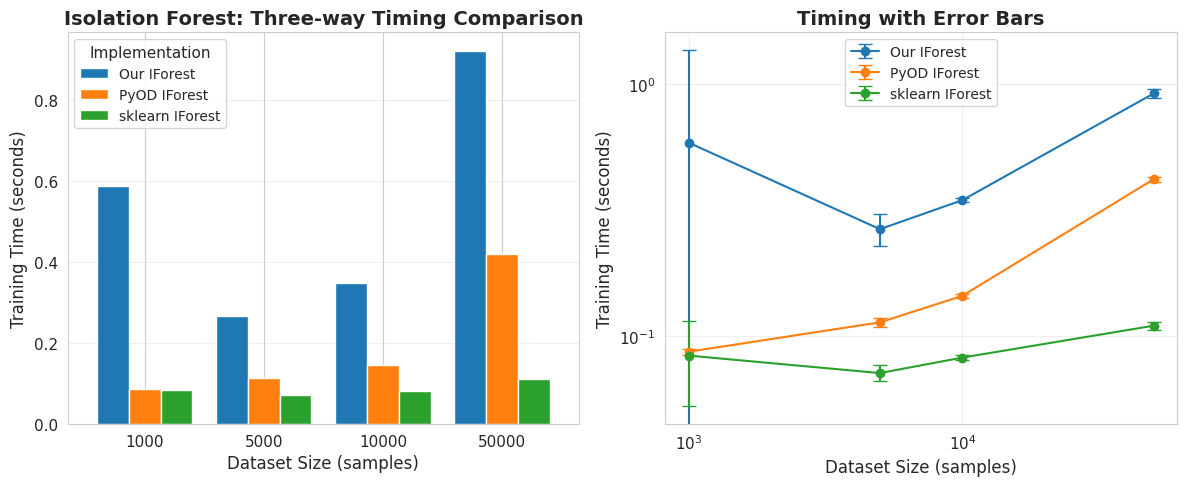


Plot saved to: results/timing/three_way_iforest_comparison.png ✅


In [5]:
plt.figure(figsize=(12, 5))

# Left Plot: Bar chart comparison
plt.subplot(1, 2, 1)
pivot_data = df_three_way.pivot(index='Dataset Size', columns='Method', values='Mean Time (s)')
pivot_data.plot(kind='bar', ax=plt.gca(), width=0.8)
plt.title('Isolation Forest: Three-way Timing Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Size (samples)', fontsize=12)
plt.ylabel('Training Time (seconds)', fontsize=12)
plt.legend(title='Implementation', fontsize=10)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()

# Right Plot: Line plot with error bars
plt.subplot(1, 2, 2)
for method in df_three_way['Method'].unique():
    subset = df_three_way[df_three_way['Method'] == method]
    plt.errorbar(subset['Dataset Size'], subset['Mean Time (s)'], 
                 yerr=subset['Std Time (s)'], marker='o', capsize=5, label=method)
plt.title('Timing with Error Bars', fontsize=14, fontweight='bold')
plt.xlabel('Dataset Size (samples)', fontsize=12)
plt.ylabel('Training Time (seconds)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.tight_layout()

plt.savefig('../results/timing/three_way_iforest_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to: results/timing/three_way_iforest_comparison.png \u2705")

### 4.2 PyOD Additional Algorithms

PyOD offers many other outlier detection algorithms. Let's compare a few fast ones:

In [6]:
from pyod.models.lof import LOF
from pyod.models.copod import COPOD
from pyod.models.ecod import ECOD

print("-"*80)
print("PyOD Additional Algorithms Comparison")
print("-"*80)

n_samples_test = 50000
X_test = generate_moons_dataset(n_normal=n_samples_test - 5000, n_anomalies=5000, seed=42)[0]

print(f"\nTesting on {n_samples_test} samples with various PyOD algorithms:\n")

algorithms = [
    ('PyOD IForest', PyODIForest(n_estimators=100, max_samples=256, random_state=42, n_jobs=-1)),
    ('PyOD LOF', LOF(n_neighbors=20, n_jobs=-1)),
    ('PyOD COPOD', COPOD()),
    ('PyOD ECOD', ECOD()),
    ('PyOD KNN', PyODKNN(n_neighbors=20, n_jobs=-1)),
    ('Our IForest', None),    # Will handle separately
    ('Our KMeans IF', None),  # Will handle separately
]

results_pyod_algos = []

for name, clf in algorithms:
    if name == 'Our IForest':
        def train_fn():
            forest = IsolationForest(ensemble_size=100, n_jobs=-1, random_state=42)
            forest.fit(X_test, subsample_size=256)
    elif name == 'Our KMeans IF':
        def train_fn():
            forest = KMeansIsolationForest(ensemble_size=100, n_jobs=-1, random_state=42)
            forest.fit(X_test, subsample_size=256)
    else:
        def train_fn():
            clf.fit(X_test)
    
    mean_time, std_time = time_execution(train_fn, n_runs=5)
    print(f"  {name:20s}: {mean_time:.4f}s \u00B1 {std_time:.4f}s")
    
    results_pyod_algos.append({
        'Algorithm': name,
        'Mean Time (s)': mean_time,
        'Std Time (s)': std_time
    })

df_pyod_algos = pd.DataFrame(results_pyod_algos)

print("\n" + "-"*80)
print("SUMMARY: PyOD Algorithms on 50K samples")
print("-"*80)
print(df_pyod_algos.sort_values('Mean Time (s)').to_string(index=False))

# Save results
df_pyod_algos.to_csv('../results/timing/pyod_algorithms_comparison.csv', index=False)

print("\nResults saved to results/timing/pyod_algorithms_comparison.csv \u2705")

--------------------------------------------------------------------------------
PyOD Additional Algorithms Comparison
--------------------------------------------------------------------------------

Testing on 50000 samples with various PyOD algorithms:

  PyOD IForest        : 0.4202s ± 0.0239s
  PyOD LOF            : 0.1445s ± 0.0055s
  PyOD COPOD          : 0.0666s ± 0.0674s
  PyOD ECOD           : 0.0312s ± 0.0076s
  PyOD KNN            : 0.1674s ± 0.0353s
  Our IForest         : 0.9324s ± 0.0301s
  Our KMeans IF       : 5.4932s ± 0.1141s

--------------------------------------------------------------------------------
SUMMARY: PyOD Algorithms on 50K samples
--------------------------------------------------------------------------------
    Algorithm  Mean Time (s)  Std Time (s)
    PyOD ECOD       0.031202      0.007573
   PyOD COPOD       0.066609      0.067363
     PyOD LOF       0.144544      0.005473
     PyOD KNN       0.167429      0.035318
 PyOD IForest       0.420153   

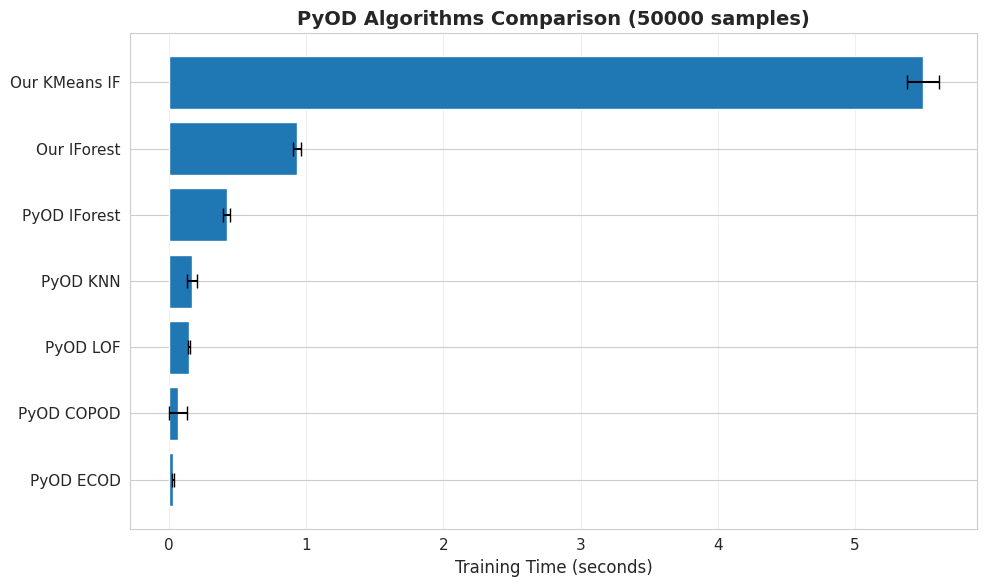


Plot saved to: results/timing/pyod_algorithms_comparison.png ✅


In [7]:
plt.figure(figsize=(10, 6))

df_sorted = df_pyod_algos.sort_values('Mean Time (s)')

plt.barh(df_sorted['Algorithm'], df_sorted['Mean Time (s)'], xerr=df_sorted['Std Time (s)'], capsize=5)

plt.xlabel('Training Time (seconds)', fontsize=12)
plt.title(f'PyOD Algorithms Comparison ({n_samples_test} samples)', fontsize=14, fontweight='bold')

plt.grid(axis='x', alpha=0.3)
plt.tight_layout()

plt.savefig('../results/timing/pyod_algorithms_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPlot saved to: results/timing/pyod_algorithms_comparison.png \u2705")

## Section 5: Summary

Consolidated view of timing results.

In [ ]:
print("-" * 80)
print("SUMMARY - ALL BENCHMARKING RESULTS")
print("-" * 80)

# Combine key findings
print("\n1. TREE VS ENSEMBLE (5,000 samples):")
subset = df_tree_vs_ensemble[df_tree_vs_ensemble['Dataset Size'] == 5000]
print(subset[['Method', 'Mean Time (s)']].to_string(index=False))

print("\n2. PARALLELIZATION SPEEDUP 5,000 samples):")
subset = df_parallel[df_parallel['Dataset Size'] == 5000]
print(subset[['Method', 'Sequential Time (s)', 'Parallel Time (s)', 'Speedup']].to_string(index=False))

print("\n3. SKLEARN COMPARISON (20,000 samples):")
subset = df_sklearn[df_sklearn['Dataset Size'] == 20000]
print(subset[['Method', 'Mean Time (s)']].to_string(index=False))

print("\n4. THREE-WAY IFOREST COMPARISON (10,000 samples):")
subset = df_three_way[df_three_way['Dataset Size'] == 10000]
print(subset[['Method', 'Mean Time (s)']].to_string(index=False))


print("\n" + "-" * 80)
print("KEY FINDINGS:")
print("-" * 80)

# Calculate average speedups
avg_speedup_if = df_parallel[df_parallel['Method'] == 'IsolationForest']['Speedup'].mean()
avg_speedup_kmif = df_parallel[df_parallel['Method'] == 'KMeansIsolationForest']['Speedup'].mean()

print(f"\nAverage parallelization speedup (IsolationForest): {avg_speedup_if:.2f}x \u2705")
print(f"Average parallelization speedup (KMeansIsolationForest): {avg_speedup_kmif:.2f}x \u2705")

print("\nAll benchmarking results saved to results/timing/ \u2705")

## Section 6: Rank Difference Analysis

Analyze how Standard Isolation Forest and K-Means Isolation Forest rank anomalies differently.
This corresponds to the analysis in Section 5.3 of the paper (Figures 3, 12, 13, 16).

In [12]:
print("-" * 80)
print("Rank Difference Analysis")
print("-" * 80)

X_rect, y_rect = generate_rectangles_dataset(n_normal=900, n_anomalies=100, seed=42)

print("\nTraining Standard Isolation Forest")
forest_std = IsolationForest(ensemble_size=100, n_jobs=-1, random_state=42)
forest_std.fit(X_rect, subsample_size=256, contamination=0.1)

print("Training K-Means Isolation Forest")
forest_kmeans = KMeansIsolationForest(ensemble_size=100, n_jobs=-1, random_state=42)
forest_kmeans.fit(X_rect, subsample_size=256, contamination=0.1)

scores_std = forest_std.scores(X_rect)
scores_kmeans = forest_kmeans.scores(X_rect)

# Calculate ranks (higher score = higher rank = more anomalous)
ranks_std = np.argsort(np.argsort(scores_std))
ranks_kmeans = np.argsort(np.argsort(scores_kmeans))

rank_diff = np.abs(ranks_std - ranks_kmeans)

print(f"\n{'Metric':<40} {'Value':>15}")
print("-" * 56)
print(f"{'Mean absolute rank difference:':<40} {rank_diff.mean():>15.2f}")
print(f"{'Median absolute rank difference:':<40} {np.median(rank_diff):>15.2f}")
print(f"{'Max absolute rank difference:':<40} {rank_diff.max():>15.0f}")
print(f"{'Std dev of rank differences:':<40} {rank_diff.std():>15.2f}")


spearman_corr, spearman_p = spearmanr(scores_std, scores_kmeans)
kendall_corr, kendall_p = kendalltau(scores_std, scores_kmeans)

print(f"\n{'Correlation Metric':<40} {'Value':>15}")
print("-" * 56)
print(f"{'Spearman rank correlation:':<40} {spearman_corr:>15.4f}")
print(f"{'Kendall rank correlation:':<40} {kendall_corr:>15.4f}")

rank_analysis_results = pd.DataFrame({
    'Point_Index': np.arange(len(X_rect)),
    'X_0': X_rect[:, 0],
    'X_1': X_rect[:, 1],
    'True_Label': y_rect,
    'Score_Std': scores_std,
    'Score_KMeans': scores_kmeans,
    'Rank_Std': ranks_std,
    'Rank_KMeans': ranks_kmeans,
    'Rank_Diff': rank_diff
})

rank_analysis_results.to_csv('../results/timing/rank_differences.csv', index=False)

print("\nRank difference analysis saved to results/timing/rank_differences.csv \u2705")

--------------------------------------------------------------------------------
Rank Difference Analysis
--------------------------------------------------------------------------------

Training Standard Isolation Forest
Training K-Means Isolation Forest

Metric                                             Value
--------------------------------------------------------
Mean absolute rank difference:                    217.73
Median absolute rank difference:                  175.50
Max absolute rank difference:                        767
Std dev of rank differences:                      175.82

Correlation Metric                                 Value
--------------------------------------------------------
Spearman rank correlation:                        0.5301
Kendall rank correlation:                         0.3704

Rank difference analysis saved to results/timing/rank_differences.csv ✅


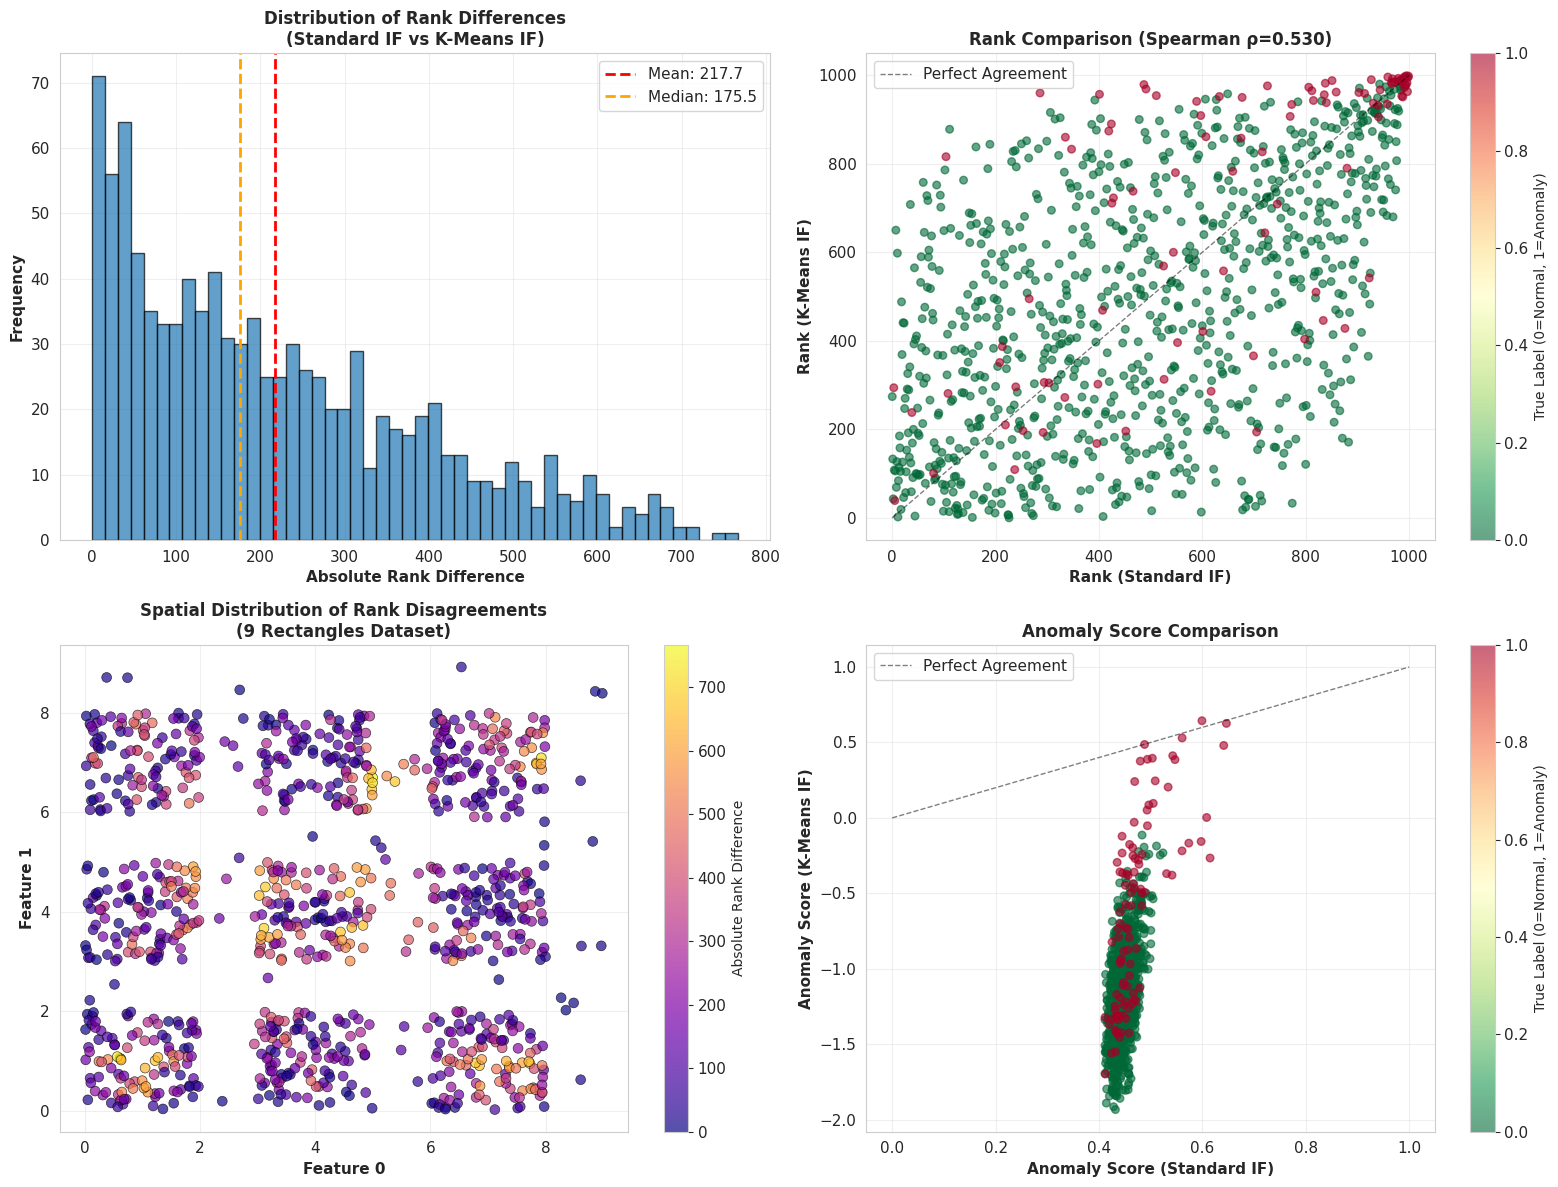

Rank difference visualizations saved to results/timing/rank_difference_analysis.png ✅


In [13]:
# Visualization: Rank Difference Analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Histogram of rank differences
ax = axes[0, 0]
ax.hist(rank_diff, bins=50, edgecolor='black', alpha=0.7)

ax.set_xlabel('Absolute Rank Difference', fontsize=11, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax.set_title('Distribution of Rank Differences\n(Standard IF vs K-Means IF)', fontsize=12, fontweight='bold')

ax.axvline(rank_diff.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {rank_diff.mean():.1f}')
ax.axvline(np.median(rank_diff), color='orange', linestyle='--', linewidth=2, label=f'Median: {np.median(rank_diff):.1f}')
ax.legend()

ax.grid(alpha=0.3)

# Plot 2: Scatter plot of ranks (Standard vs K-Means)
ax = axes[0, 1]
scatter = ax.scatter(ranks_std, ranks_kmeans, c=y_rect, cmap='RdYlGn_r', alpha=0.6, s=30)

ax.plot([0, len(X_rect)], [0, len(X_rect)], 'k--', linewidth=1, alpha=0.5, label='Perfect Agreement')
ax.set_xlabel('Rank (Standard IF)', fontsize=11, fontweight='bold')
ax.set_ylabel('Rank (K-Means IF)', fontsize=11, fontweight='bold')
ax.set_title(f'Rank Comparison (Spearman ρ={spearman_corr:.3f})', fontsize=12, fontweight='bold')

ax.legend()

ax.grid(alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('True Label (0=Normal, 1=Anomaly)', fontsize=10)

# Plot 3: Spatial visualization of disagreements (2D data only)
ax = axes[1, 0]

# Color by rank difference magnitude
scatter = ax.scatter(X_rect[:, 0], X_rect[:, 1], c=rank_diff, cmap='plasma', 
                     alpha=0.7, s=50, edgecolors='black', linewidth=0.5)

ax.set_xlabel('Feature 0', fontsize=11, fontweight='bold')
ax.set_ylabel('Feature 1', fontsize=11, fontweight='bold')
ax.set_title('Spatial Distribution of Rank Disagreements\n(9 Rectangles Dataset)', fontsize=12, fontweight='bold')

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Rank Difference', fontsize=10)
ax.grid(alpha=0.3)

# Plot 4: Anomaly scores comparison
ax = axes[1, 1]
scatter = ax.scatter(scores_std, scores_kmeans, c=y_rect, cmap='RdYlGn_r', alpha=0.6, s=30)

ax.plot([0, 1], [0, 1], 'k--', linewidth=1, alpha=0.5, label='Perfect Agreement')
ax.set_xlabel('Anomaly Score (Standard IF)', fontsize=11, fontweight='bold')
ax.set_ylabel('Anomaly Score (K-Means IF)', fontsize=11, fontweight='bold')
ax.set_title('Anomaly Score Comparison', fontsize=12, fontweight='bold')

ax.legend()

ax.grid(alpha=0.3)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('True Label (0=Normal, 1=Anomaly)', fontsize=10)

plt.tight_layout()
plt.savefig('../results/timing/rank_difference_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Rank difference visualizations saved to results/timing/rank_difference_analysis.png \u2705")

## Section 7: Prediction Time Benchmarking

Measure the time required for scoring (prediction) phase, which was missing from previous benchmarks.
Compare single sample prediction vs batch prediction performance.

In [29]:
print("-" * 80)
print("Prediction Time Benchmarking")
print("-" * 80)

# Test configurations
dataset_sizes = [1000, 5000, 10000, 20000]
n_runs = 10  # More runs for prediction since it's faster
ensemble_size = 100
subsample_size = 256

results_prediction = []

for n_samples in dataset_sizes:
    print(f"\n{'Testing dataset size:':<30} {n_samples:,} samples")
    
    X, y = generate_synthetic_dataset(n_samples, n_features=10, seed=42)
    
    forest_std = IsolationForest(ensemble_size=ensemble_size, n_jobs=-1, random_state=42)
    forest_std.fit(X, subsample_size=subsample_size, contamination=0.1)
    
    forest_kmeans = KMeansIsolationForest(ensemble_size=ensemble_size, n_jobs=-1, random_state=42)
    forest_kmeans.fit(X, subsample_size=subsample_size, contamination=0.1)
    
    # 1. Standard IF - Batch prediction
    def predict_std_batch():
        forest_std.scores(X)
    
    mean_time, std_time = time_execution(predict_std_batch, n_runs=n_runs)
    print(f"  {'IsolationForest (batch):':<35} {mean_time:.4f} ± {std_time:.4f} sec")
    results_prediction.append({
        'Dataset Size': n_samples,
        'Method': 'IsolationForest',
        'Prediction Type': 'Batch',
        'Mean Time (s)': mean_time,
        'Std Time (s)': std_time,
        'Time per Sample (ms)': (mean_time / n_samples) * 1000
    })
    
    # 2. K-Means IF - Batch prediction
    def predict_kmeans_batch():
        forest_kmeans.scores(X)
    
    mean_time, std_time = time_execution(predict_kmeans_batch, n_runs=n_runs)
    print(f"  {'KMeansIsolationForest (batch):':<35} {mean_time:.4f} ± {std_time:.4f} sec")
    results_prediction.append({
        'Dataset Size': n_samples,
        'Method': 'KMeansIsolationForest',
        'Prediction Type': 'Batch',
        'Mean Time (s)': mean_time,
        'Std Time (s)': std_time,
        'Time per Sample (ms)': (mean_time / n_samples) * 1000
    })
    
    # 3. sklearn IF - Batch prediction
    sklearn_forest = SklearnIsolationForest(n_estimators=ensemble_size, max_samples=subsample_size, 
                                            contamination=0.1, random_state=42, n_jobs=-1)
    sklearn_forest.fit(X)
    
    def predict_sklearn_batch():
        sklearn_forest.score_samples(X)
    
    mean_time, std_time = time_execution(predict_sklearn_batch, n_runs=n_runs)
    print(f"  {'sklearn IsolationForest (batch):':<35} {mean_time:.4f} ± {std_time:.4f} sec")
    results_prediction.append({
        'Dataset Size': n_samples,
        'Method': 'sklearn IsolationForest',
        'Prediction Type': 'Batch',
        'Mean Time (s)': mean_time,
        'Std Time (s)': std_time,
        'Time per Sample (ms)': (mean_time / n_samples) * 1000
    })

# Create DataFrame
df_prediction = pd.DataFrame(results_prediction)

print("\n" + "-" * 80)
print("Summary:")
print("-" * 80)
print(df_prediction.to_string(index=False))

# Save results
df_prediction.to_csv('../results/timing/prediction_times.csv', index=False)

print("\nResults saved to results/timing/prediction_times.csv")

--------------------------------------------------------------------------------
Prediction Time Benchmarking
--------------------------------------------------------------------------------

Testing dataset size:          1,000 samples
  IsolationForest (batch):            0.0868 ± 0.0031 sec
  KMeansIsolationForest (batch):      0.3773 ± 0.0322 sec
  sklearn IsolationForest (batch):    0.0051 ± 0.0000 sec

Testing dataset size:          5,000 samples
  IsolationForest (batch):            0.1260 ± 0.0249 sec
  KMeansIsolationForest (batch):      0.4636 ± 0.0214 sec
  sklearn IsolationForest (batch):    0.0144 ± 0.0002 sec

Testing dataset size:          10,000 samples
  IsolationForest (batch):            0.1774 ± 0.0150 sec
  KMeansIsolationForest (batch):      0.5116 ± 0.0250 sec
  sklearn IsolationForest (batch):    0.0259 ± 0.0008 sec

Testing dataset size:          20,000 samples
  IsolationForest (batch):            0.2586 ± 0.0650 sec
  KMeansIsolationForest (batch):      0.508

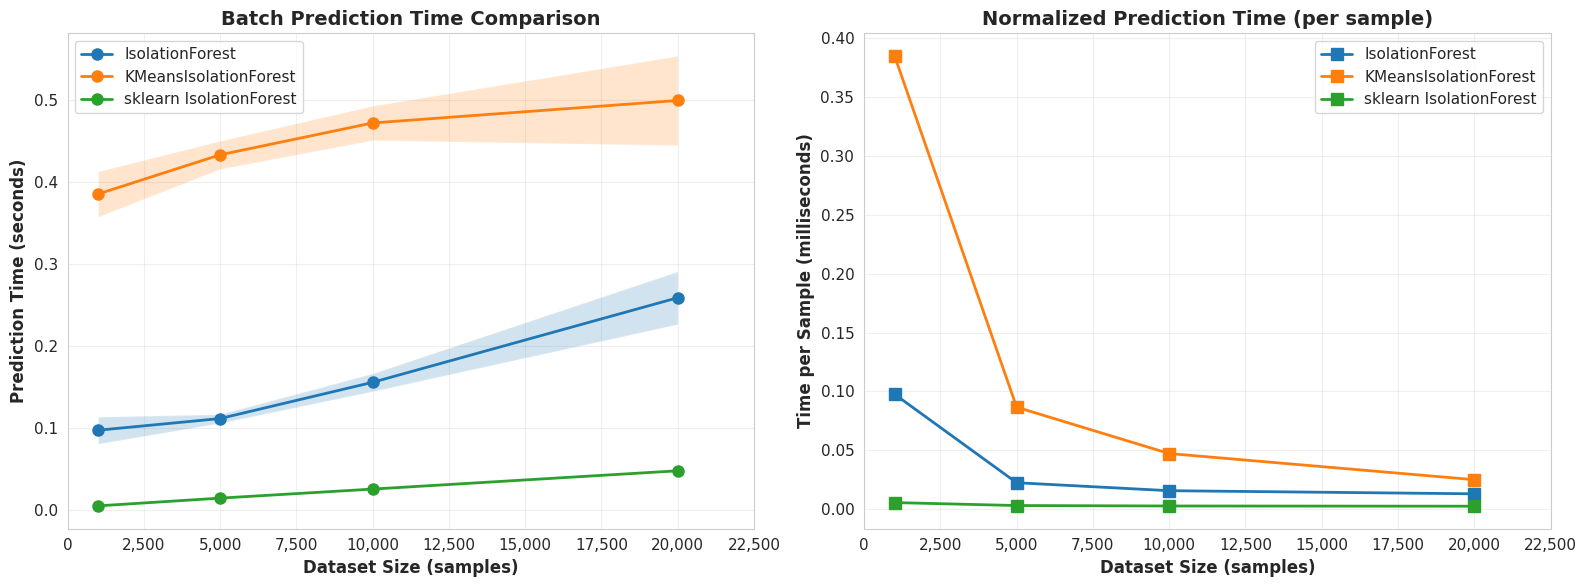

Prediction time plots saved to results/timing/prediction_times.png ✅


In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left Plot: Absolute prediction time
batch_data = df_prediction[df_prediction['Prediction Type'] == 'Batch']
for method in batch_data['Method'].unique():
    method_data = batch_data[batch_data['Method'] == method]
    ax1.plot(method_data['Dataset Size'], method_data['Mean Time (s)'], 
            marker='o', linewidth=2, markersize=8, label=method)
    
    # Add error bars
    ax1.fill_between(
        method_data['Dataset Size'],
        method_data['Mean Time (s)'] - method_data['Std Time (s)'],
        method_data['Mean Time (s)'] + method_data['Std Time (s)'],
        alpha=0.2
    )

ax1.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Prediction Time (seconds)', fontsize=12, fontweight='bold')
ax1.set_title('Batch Prediction Time Comparison', fontsize=14, fontweight='bold')

ax1.legend()

ax1.grid(alpha=0.3)

ticks = ax1.get_xticks()
ax1.set_xticks(ticks)
ax1.set_xticklabels([f'{int(t):,}' for t in ticks])

# Right Plot: Time per sample (normalized)
for method in batch_data['Method'].unique():
    method_data = batch_data[batch_data['Method'] == method]
    ax2.plot(method_data['Dataset Size'], method_data['Time per Sample (ms)'], 
            marker='s', linewidth=2, markersize=8, label=method)

ax2.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Time per Sample (milliseconds)', fontsize=12, fontweight='bold')
ax2.set_title('Normalized Prediction Time (per sample)', fontsize=14, fontweight='bold')

ax2.legend()

ax2.grid(alpha=0.3)
ticks = ax2.get_xticks()
ax2.set_xticks(ticks)
ax2.set_xticklabels([f'{int(t):,}' for t in ticks])

plt.tight_layout()
plt.savefig('../results/timing/prediction_times.png', dpi=300, bbox_inches='tight')
plt.show()

print("Prediction time plots saved to results/timing/prediction_times.png \u2705")

## Section 8: Large Dataset Scaling (100K+ samples)

Test scalability on large datasets (100K and 500K samples)

In [16]:
print("-" * 80)
print("Large Dataset Scaling")
print("-" * 80)

RUN_LARGE_TESTS = True

if RUN_LARGE_TESTS:
    # Test configurations
    large_dataset_sizes = [100_000, 500_000]  # Can add 1_000_000 if you have time
    n_runs = 3  # Fewer runs for large datasets
    ensemble_size = 50  # Smaller ensemble for faster testing
    subsample_size = 256
    
    results_large = []
    
    for n_samples in large_dataset_sizes:
        print(f"\n{'-' * 80}")
        print(f"Testing dataset size: {n_samples:,} samples")
        print(f"{'-' * 80}")
        
        print(f"Generating {n_samples:,} samples")
        X, y = generate_synthetic_dataset(n_samples, n_features=10, seed=42)

        print(f"Dataset generated: {X.shape} samples\n")
        
        # 1. Standard IsolationForest
        print(f"\n{'Method':<40} {'Status':<20}")
        print("-" * 60)
        
        def train_std_large():
            forest = IsolationForest(ensemble_size=ensemble_size, n_jobs=-1, random_state=42)
            forest.fit(X, subsample_size=subsample_size, contamination=0.1)
        
        print(f"{'IsolationForest (training):':<40} {'Running...':<20}", end='', flush=True)
        mean_time_train, std_time_train = time_execution(train_std_large, n_runs=n_runs)
        print(f"\r{'IsolationForest (training):':<40} {mean_time_train:.2f} ± {std_time_train:.2f} sec")
        
        # Train once for prediction timing
        forest_std = IsolationForest(ensemble_size=ensemble_size, n_jobs=-1, random_state=42)
        forest_std.fit(X, subsample_size=subsample_size, contamination=0.1)
        
        def predict_std_large():
            forest_std.scores(X)
        
        print(f"{'IsolationForest (prediction):':<40} {'Running...':<20}", end='', flush=True)
        mean_time_pred, std_time_pred = time_execution(predict_std_large, n_runs=n_runs)
        print(f"\r{'IsolationForest (prediction):':<40} {mean_time_pred:.2f} ± {std_time_pred:.2f} sec")
        
        results_large.append({
            'Dataset Size': n_samples,
            'Method': 'IsolationForest',
            'Training Time (s)': mean_time_train,
            'Training Std (s)': std_time_train,
            'Prediction Time (s)': mean_time_pred,
            'Prediction Std (s)': std_time_pred,
            'Total Time (s)': mean_time_train + mean_time_pred
        })
        
        # 2. K-Means IsolationForest (fast mode)
        def train_kmeans_large():
            forest = KMeansIsolationForest(ensemble_size=ensemble_size, n_jobs=-1, random_state=42)
            forest.fit(X, subsample_size=subsample_size, contamination=0.1)
        
        print(f"{'KMeansIsolationForest (training):':<40} {'Running...':<20}", end='', flush=True)

        mean_time_train, std_time_train = time_execution(train_kmeans_large, n_runs=n_runs)

        print(f"\r{'KMeansIsolationForest (training):':<40} {mean_time_train:.2f} ± {std_time_train:.2f} sec")
        
        # Train once for prediction timing
        forest_kmeans = KMeansIsolationForest(ensemble_size=ensemble_size, n_jobs=-1, random_state=42)
        forest_kmeans.fit(X, subsample_size=subsample_size, contamination=0.1)
        
        def predict_kmeans_large():
            forest_kmeans.scores(X)
        
        print(f"{'KMeansIsolationForest (prediction):':<40} {'Running...':<20}", end='', flush=True)

        mean_time_pred, std_time_pred = time_execution(predict_kmeans_large, n_runs=n_runs)

        print(f"\r{'KMeansIsolationForest (prediction):':<40} {mean_time_pred:.2f} ± {std_time_pred:.2f} sec")
        
        results_large.append({
            'Dataset Size': n_samples,
            'Method': 'KMeansIsolationForest',
            'Training Time (s)': mean_time_train,
            'Training Std (s)': std_time_train,
            'Prediction Time (s)': mean_time_pred,
            'Prediction Std (s)': std_time_pred,
            'Total Time (s)': mean_time_train + mean_time_pred
        })
        
        # 3. sklearn IsolationForest
        def train_sklearn_large():
            forest = SklearnIsolationForest(n_estimators=ensemble_size, max_samples=subsample_size, 
                                           contamination=0.1, random_state=42, n_jobs=-1)
            forest.fit(X)
        
        print(f"{'sklearn IsolationForest (training):':<40} {'Running...':<20}", end='', flush=True)

        mean_time_train, std_time_train = time_execution(train_sklearn_large, n_runs=n_runs)

        print(f"\r{'sklearn IsolationForest (training):':<40} {mean_time_train:.2f} ± {std_time_train:.2f} sec")
        
        # Train once for prediction timing
        sklearn_forest = SklearnIsolationForest(n_estimators=ensemble_size, max_samples=subsample_size, 
                                                contamination=0.1, random_state=42, n_jobs=-1)
        sklearn_forest.fit(X)
        
        def predict_sklearn_large():
            sklearn_forest.score_samples(X)
        
        print(f"{'sklearn IsolationForest (prediction):':<40} {'Running...':<20}", end='', flush=True)

        mean_time_pred, std_time_pred = time_execution(predict_sklearn_large, n_runs=n_runs)

        print(f"\r{'sklearn IsolationForest (prediction):':<40} {mean_time_pred:.2f} ± {std_time_pred:.2f} sec")
        
        results_large.append({
            'Dataset Size': n_samples,
            'Method': 'sklearn IsolationForest',
            'Training Time (s)': mean_time_train,
            'Training Std (s)': std_time_train,
            'Prediction Time (s)': mean_time_pred,
            'Prediction Std (s)': std_time_pred,
            'Total Time (s)': mean_time_train + mean_time_pred
        })
        
        print(f"\nCompleted {n_samples:,} samples")
    
    # Create DataFrame
    df_large = pd.DataFrame(results_large)
    
    print("\n" + "-" * 80)
    print("Summary:")
    print("-" * 80)
    print(df_large.to_string(index=False))
    
    # Calculate speedup ratios
    print("\n" + "-" * 80)
    print("Speedup Analysis (500K samples):")
    print("-" * 80)
    if 500_000 in df_large['Dataset Size'].values:
        subset_500k = df_large[df_large['Dataset Size'] == 500_000]
        std_time = subset_500k[subset_500k['Method'] == 'IsolationForest']['Total Time (s)'].values[0]
        kmeans_time = subset_500k[subset_500k['Method'] == 'KMeansIsolationForest']['Total Time (s)'].values[0]
        speedup = std_time / kmeans_time
        
        print(f"Standard IF total time: {std_time:.2f} sec")
        print(f"K-Means IF total time:  {kmeans_time:.2f} sec")
        print(f"Speedup ratio:          {speedup:.2f}x")
        print(f"\nPaper claims: 45x speedup on 500K samples (NYC taxi dataset)")
        print(f"Our result:   {speedup:.2f}x speedup on 500K samples (synthetic dataset)")
        print(f"\nNote: Difference may be due to dataset characteristics, fast_mode, or ensemble size.")
    
    # Save results
    df_large.to_csv('../results/timing/large_dataset_scaling.csv', index=False)
    print("\n✓ Results saved to results/timing/large_dataset_scaling.csv")
else:
    print("\nLarge dataset tests skipped (RUN_LARGE_TESTS = False)")
    print("    Set RUN_LARGE_TESTS = True to run these tests")

--------------------------------------------------------------------------------
Large Dataset Scaling
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Testing dataset size: 100,000 samples
--------------------------------------------------------------------------------
Generating 100,000 samples
Dataset generated: (100000, 10) samples


Method                                   Status              
------------------------------------------------------------
IsolationForest (training):              0.96 ± 0.04 sec     
IsolationForest (prediction):            0.71 ± 0.05 sec     
KMeansIsolationForest (training):        4.36 ± 0.15 sec     
KMeansIsolationForest (prediction):      0.59 ± 0.02 sec     
sklearn IsolationForest (training):      0.17 ± 0.00 sec     
sklearn IsolationForest (prediction):    0.11 ± 0.00 sec     

Completed 100,000 samples

-----------------------

/tmp/ipykernel_10745/3054121464.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels([f'{int(tick):,}' for tick in ax2.get_xticks()])


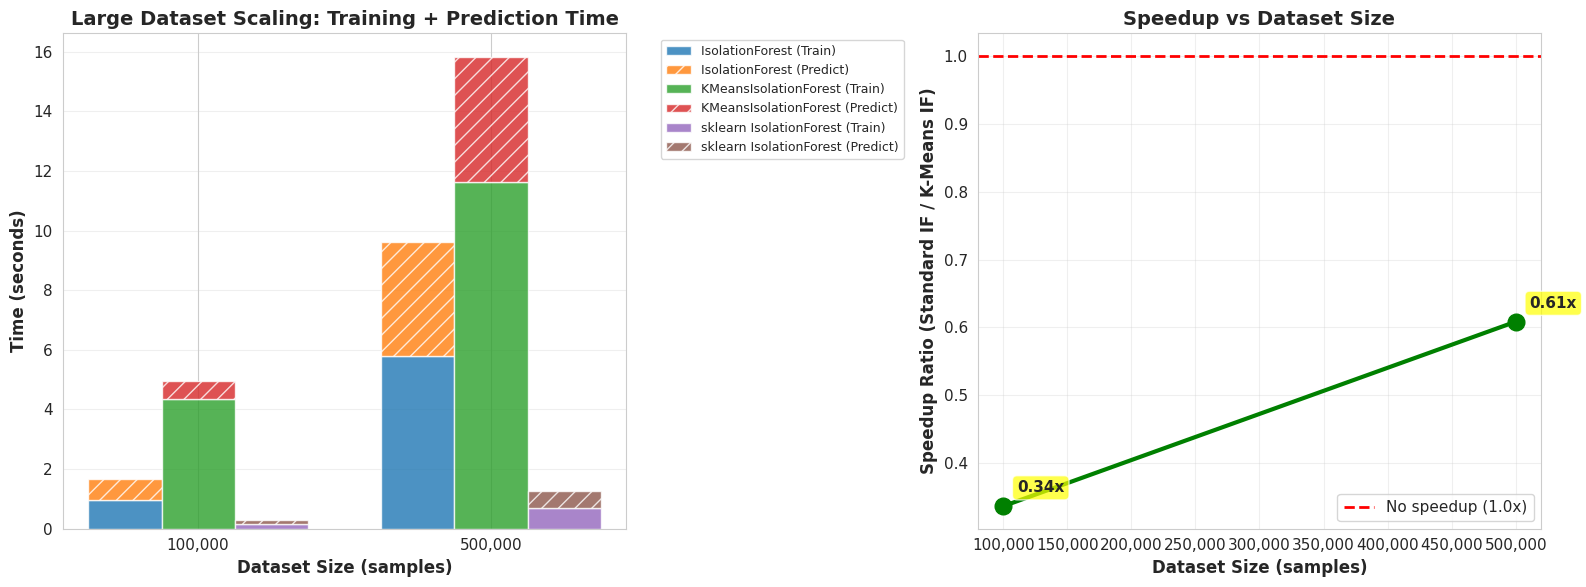

Large dataset scaling plots saved to results/timing/large_dataset_scaling.png ✅


In [17]:
if RUN_LARGE_TESTS:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Left Plot: Training + Prediction time breakdown
    methods = df_large['Method'].unique()
    x = np.arange(len(df_large['Dataset Size'].unique()))
    width = 0.25
    
    for i, method in enumerate(methods):
        method_data = df_large[df_large['Method'] == method]
        offset = width * (i - 1)
        
        # Stacked bars: training + prediction
        ax1.bar(x + offset, method_data['Training Time (s)'], width, 
               label=f'{method} (Train)', alpha=0.8)
        ax1.bar(x + offset, method_data['Prediction Time (s)'], width, 
               bottom=method_data['Training Time (s)'],
               label=f'{method} (Predict)', alpha=0.8, hatch='//')
    
    ax1.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
    ax1.set_ylabel('Time (seconds)', fontsize=12, fontweight='bold')
    ax1.set_title('Large Dataset Scaling: Training + Prediction Time', fontsize=14, fontweight='bold')

    ax1.set_xticks(x)
    ax1.set_xticklabels([f'{size:,}' for size in df_large['Dataset Size'].unique()])

    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=9)
    ax1.grid(axis='y', alpha=0.3)
    
    # Plot 2: Speedup comparison
    dataset_sizes_unique = sorted(df_large['Dataset Size'].unique())
    speedups = []
    
    for size in dataset_sizes_unique:
        subset = df_large[df_large['Dataset Size'] == size]
        std_time = subset[subset['Method'] == 'IsolationForest']['Total Time (s)'].values[0]
        kmeans_time = subset[subset['Method'] == 'KMeansIsolationForest']['Total Time (s)'].values[0]
        speedup = std_time / kmeans_time
        speedups.append(speedup)
    
    ax2.plot(dataset_sizes_unique, speedups, marker='o', linewidth=3, markersize=12, color='green')

    ax2.axhline(y=1.0, color='red', linestyle='--', linewidth=2, label='No speedup (1.0x)')

    ax2.set_xlabel('Dataset Size (samples)', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Speedup Ratio (Standard IF / K-Means IF)', fontsize=12, fontweight='bold')
    ax2.set_title('Speedup vs Dataset Size', fontsize=14, fontweight='bold')

    ticks = ax2.get_xticks()
    ax2.set_xticks(ticks)
    ax2.set_xticklabels([f'{int(t):,}' for t in ticks])

    ax2.legend()
    ax2.grid(alpha=0.3)
    
    # Annotate speedup values
    for size, speedup in zip(dataset_sizes_unique, speedups):
        ax2.annotate(f'{speedup:.2f}x', xy=(size, speedup), xytext=(10, 10),
                    textcoords='offset points', fontsize=11, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    plt.tight_layout()

    plt.savefig('../results/timing/large_dataset_scaling.png', dpi=300, bbox_inches='tight')

    plt.show()
    
    print("Large dataset scaling plots saved to results/timing/large_dataset_scaling.png \u2705")
else:
    print("Visualization skipped (RUN_LARGE_TESTS = False)")

## Section 9: Prediction Accuracy Comparison

Measure and compare the prediction accuracy of our implementations on various synthetic datasets.
This section complements the timing analysis by evaluating detection quality.

In [18]:
from sklearn.metrics import (
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    average_precision_score,
    confusion_matrix,
    roc_curve,
    precision_recall_curve
)
from sklearn.model_selection import train_test_split

print("-" * 80)
print("Prediction Accuracy Comparison")
print("-" * 80)

# Test configurations
datasets_for_accuracy = [
    ('9 Rectangles', generate_rectangles_dataset, {}),
    ('Moons', generate_moons_dataset, {}),
    ('Circles', generate_circles_dataset, {}),
    ('High-Dim (10D)', generate_synthetic_dataset, {'n_samples': 10000, 'n_features': 10}),
    ('Synthetic (20D)', generate_synthetic_dataset, {'n_samples': 20000, 'n_features': 20})
]

ensemble_size = 100
subsample_size = 256
results_accuracy = []

for dataset_name, generator, kwargs in datasets_for_accuracy:
    print(f"\n{'-' * 80}")
    print(f"Dataset: {dataset_name}")
    print(f"{'-' * 80}")
    
    X, y = generator(**kwargs) if kwargs else generator()
    
    # Split into train/test (80/20) with stratification
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    contamination = np.mean(y_train)
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    print(f"Contamination: {contamination:.2%}\n")
    
    # 1. Our IsolationForest
    print(f"{'Method':<30} {'Training...':<15}", end='', flush=True)
    forest_std = IsolationForest(ensemble_size=ensemble_size, n_jobs=-1, random_state=42)
    forest_std.fit(X_train, subsample_size=subsample_size, contamination=contamination)
    
    scores_std = forest_std.scores(X_test)
    preds_std = forest_std.predict(X_test)
    
    bal_acc = balanced_accuracy_score(y_test, preds_std)

    f1 = f1_score(y_test, preds_std)

    precision = precision_score(y_test, preds_std, zero_division=0)

    recall = recall_score(y_test, preds_std)

    roc_auc = roc_auc_score(y_test, scores_std)

    avg_precision = average_precision_score(y_test, scores_std)
    
    print(f"\r{'IsolationForest':<30} {'✓ Complete':<15}")
    print(f"  Balanced Acc: {bal_acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f} | PR-AUC: {avg_precision:.4f}")
    
    results_accuracy.append({
        'Dataset': dataset_name,
        'Method': 'IsolationForest',
        'Balanced Accuracy': bal_acc,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC-AUC': roc_auc,
        'PR-AUC': avg_precision
    })
    
    # 2. Our KMeansIsolationForest
    print(f"\n{'KMeansIsolationForest':<30} {'Training...':<15}", end='', flush=True)
    forest_kmeans = KMeansIsolationForest(ensemble_size=ensemble_size, n_jobs=-1, random_state=42)
    forest_kmeans.fit(X_train, subsample_size=subsample_size, contamination=contamination)
    
    scores_kmeans = forest_kmeans.scores(X_test)

    preds_kmeans = forest_kmeans.predict(X_test)
    
    # Calculate metrics
    bal_acc = balanced_accuracy_score(y_test, preds_kmeans)

    f1 = f1_score(y_test, preds_kmeans)

    precision = precision_score(y_test, preds_kmeans, zero_division=0)

    recall = recall_score(y_test, preds_kmeans)

    roc_auc = roc_auc_score(y_test, scores_kmeans)

    avg_precision = average_precision_score(y_test, scores_kmeans)
    
    print(f"\r{'KMeansIsolationForest':<30} {'✓ Complete':<15}")
    print(f"  Balanced Acc: {bal_acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f} | PR-AUC: {avg_precision:.4f}")
    
    results_accuracy.append({
        'Dataset': dataset_name,
        'Method': 'KMeansIsolationForest',
        'Balanced Accuracy': bal_acc,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC-AUC': roc_auc,
        'PR-AUC': avg_precision
    })
    
    # 3. sklearn IsolationForest
    print(f"\n{'sklearn IsolationForest':<30} {'Training...':<15}", end='', flush=True)
    sklearn_forest = SklearnIsolationForest(
        n_estimators=ensemble_size,
        max_samples=subsample_size,
        contamination=contamination,
        random_state=42,
        n_jobs=-1
    )
    sklearn_forest.fit(X_train)
    
    scores_sklearn = -sklearn_forest.score_samples(X_test)  # Negate for consistency (higher = more anomalous)
    preds_sklearn = (sklearn_forest.predict(X_test) == -1).astype(int)  # -1 for outliers, 1 for inliers
    
    # Calculate metrics
    bal_acc = balanced_accuracy_score(y_test, preds_sklearn)

    f1 = f1_score(y_test, preds_sklearn)

    precision = precision_score(y_test, preds_sklearn, zero_division=0)

    recall = recall_score(y_test, preds_sklearn)

    roc_auc = roc_auc_score(y_test, scores_sklearn)

    avg_precision = average_precision_score(y_test, scores_sklearn)
    
    print(f"\r{'sklearn IsolationForest':<30} {'✓ Complete':<15}")
    print(f"  Balanced Acc: {bal_acc:.4f} | F1: {f1:.4f} | Precision: {precision:.4f} | Recall: {recall:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f} | PR-AUC: {avg_precision:.4f}")
    
    results_accuracy.append({
        'Dataset': dataset_name,
        'Method': 'sklearn IsolationForest',
        'Balanced Accuracy': bal_acc,
        'F1-Score': f1,
        'Precision': precision,
        'Recall': recall,
        'ROC-AUC': roc_auc,
        'PR-AUC': avg_precision
    })

# Create DataFrame
df_accuracy = pd.DataFrame(results_accuracy)

print("\n" + "-" * 80)
print("ACCURACY SUMMARY")
print("-" * 80)
print(df_accuracy.to_string(index=False))

# Save results
df_accuracy.to_csv('../results/timing/prediction_accuracy.csv', index=False)
print("\nResults saved to results/timing/prediction_accuracy.csv \u2705")

--------------------------------------------------------------------------------
Prediction Accuracy Comparison
--------------------------------------------------------------------------------

--------------------------------------------------------------------------------
Dataset: 9 Rectangles
--------------------------------------------------------------------------------
Train size: 800, Test size: 200
Contamination: 10.00%

IsolationForest                ✓ Complete     
  Balanced Acc: 0.6722 | F1: 0.3750 | Precision: 0.3214 | Recall: 0.4500
  ROC-AUC: 0.7825 | PR-AUC: 0.4513

KMeansIsolationForest          ✓ Complete     
  Balanced Acc: 0.7028 | F1: 0.3218 | Precision: 0.2090 | Recall: 0.7000
  ROC-AUC: 0.7836 | PR-AUC: 0.5812

sklearn IsolationForest        ✓ Complete     
  Balanced Acc: 0.5750 | F1: 0.2326 | Precision: 0.2174 | Recall: 0.2500
  ROC-AUC: 0.6911 | PR-AUC: 0.2802

--------------------------------------------------------------------------------
Dataset: Moons
---

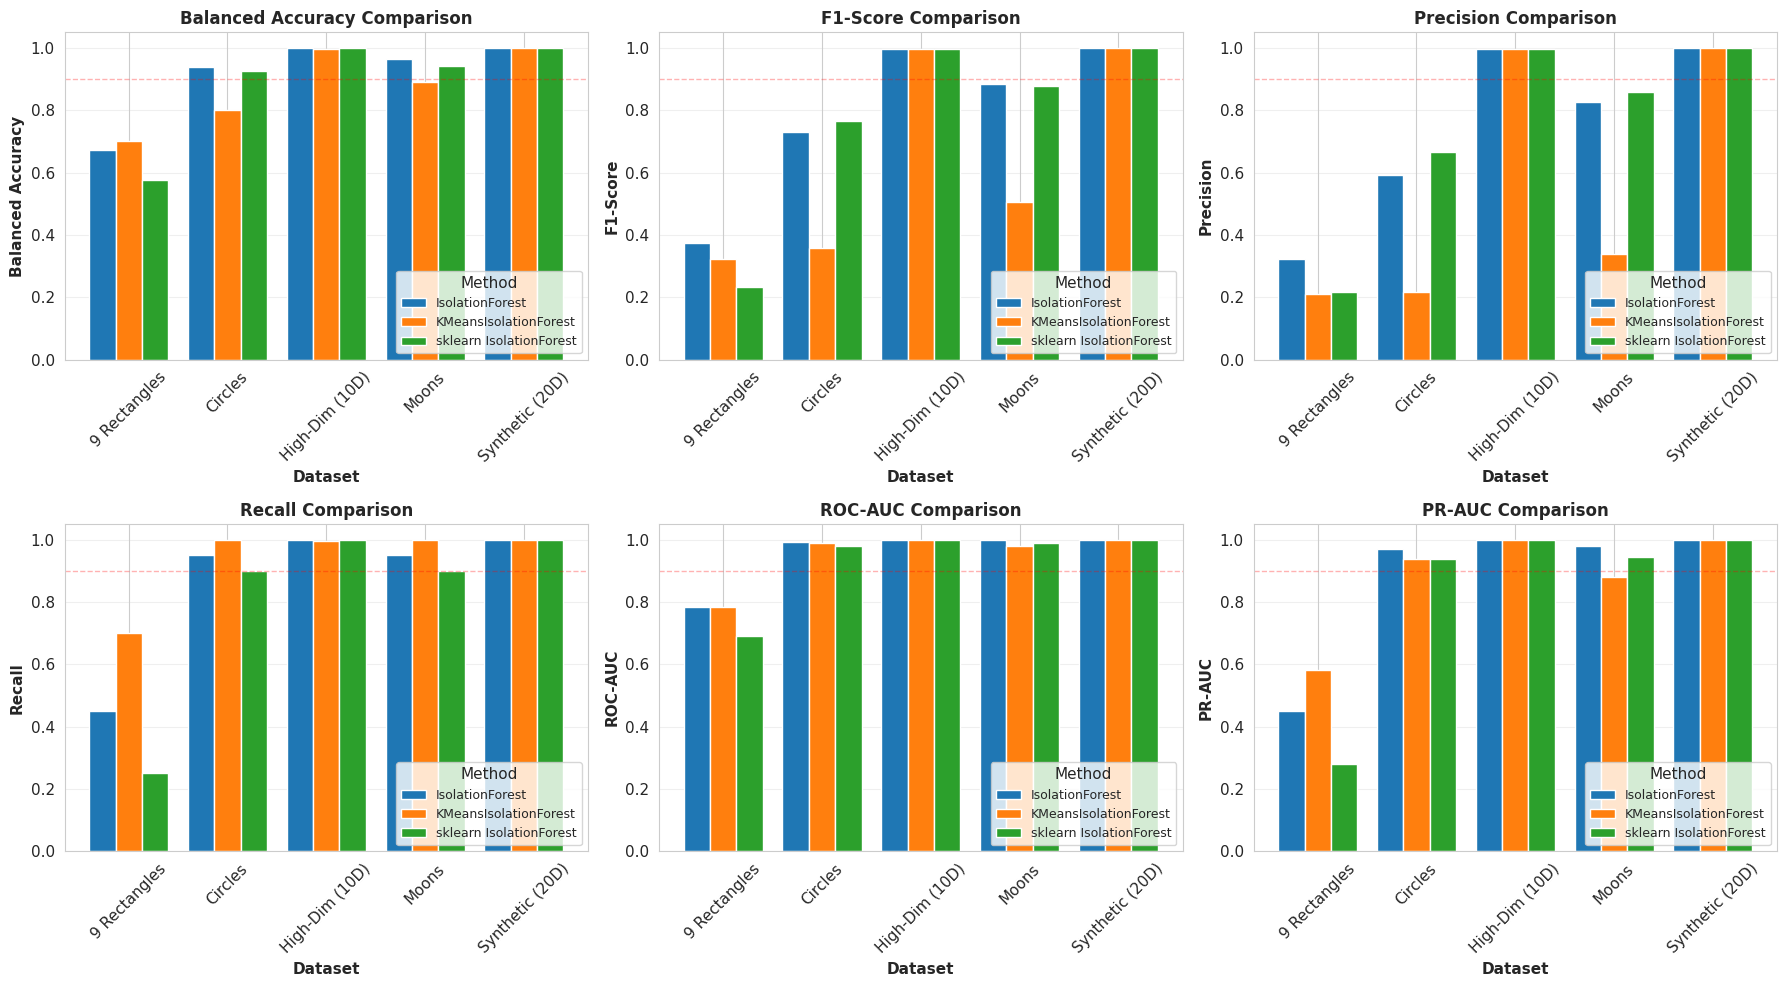

Accuracy metrics plot saved to results/timing/accuracy_metrics_comparison.png ✅


In [25]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

metrics = ['Balanced Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC-AUC', 'PR-AUC']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    # Pivot data for grouped bar chart
    pivot_df = df_accuracy.pivot(index='Dataset', columns='Method', values=metric)
    
    pivot_df.plot(kind='bar', ax=ax, width=0.8, rot=45)

    ax.set_xlabel('Dataset', fontsize=11, fontweight='bold')
    ax.set_ylabel(metric, fontsize=11, fontweight='bold')
    ax.set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')

    ax.legend(title='Method', fontsize=9, loc='lower right')

    ax.grid(axis='y', alpha=0.3)

    ax.set_ylim([0, 1.05])
    
    # Add horizontal line at 0.9 for reference
    ax.axhline(y=0.9, color='red', linestyle='--', alpha=0.3, linewidth=1)

plt.tight_layout()

plt.savefig('../results/timing/accuracy_metrics_comparison.png', dpi=300, bbox_inches='tight')

plt.show()

print("Accuracy metrics plot saved to results/timing/accuracy_metrics_comparison.png \u2705")

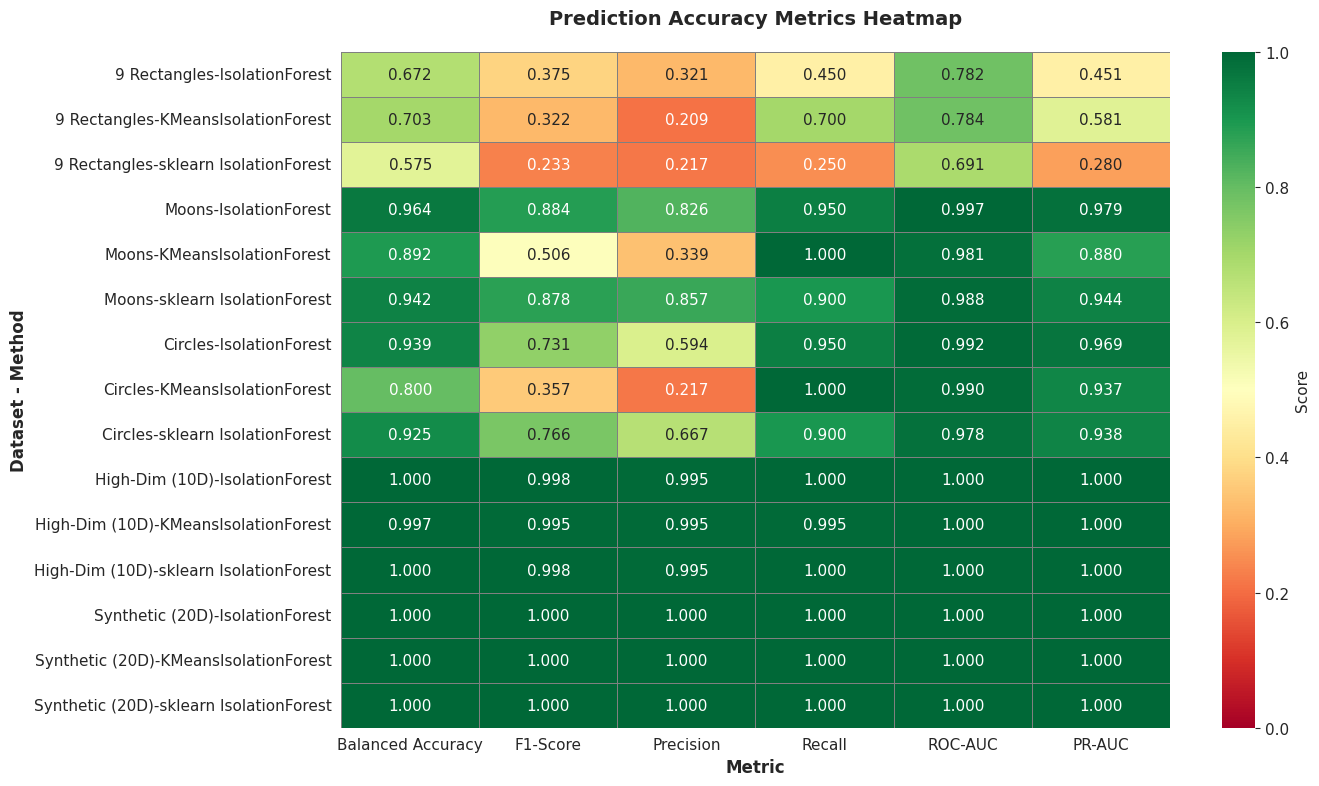

Accuracy heatmap saved to results/timing/accuracy_heatmap.png ✅


In [24]:
fig, ax = plt.subplots(figsize=(14, 8))

df_accuracy['Dataset-Method'] = df_accuracy['Dataset'] + "-" + df_accuracy['Method']

heatmap_data = df_accuracy.set_index('Dataset-Method')[metrics]

# Create heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            vmin=0, vmax=1, cbar_kws={'label': 'Score'},
            linewidths=0.5, linecolor='gray', ax=ax)

ax.set_title('Prediction Accuracy Metrics Heatmap', fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Metric', fontsize=12, fontweight='bold')
ax.set_ylabel('Dataset - Method', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('../results/timing/accuracy_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Accuracy heatmap saved to results/timing/accuracy_heatmap.png \u2705")

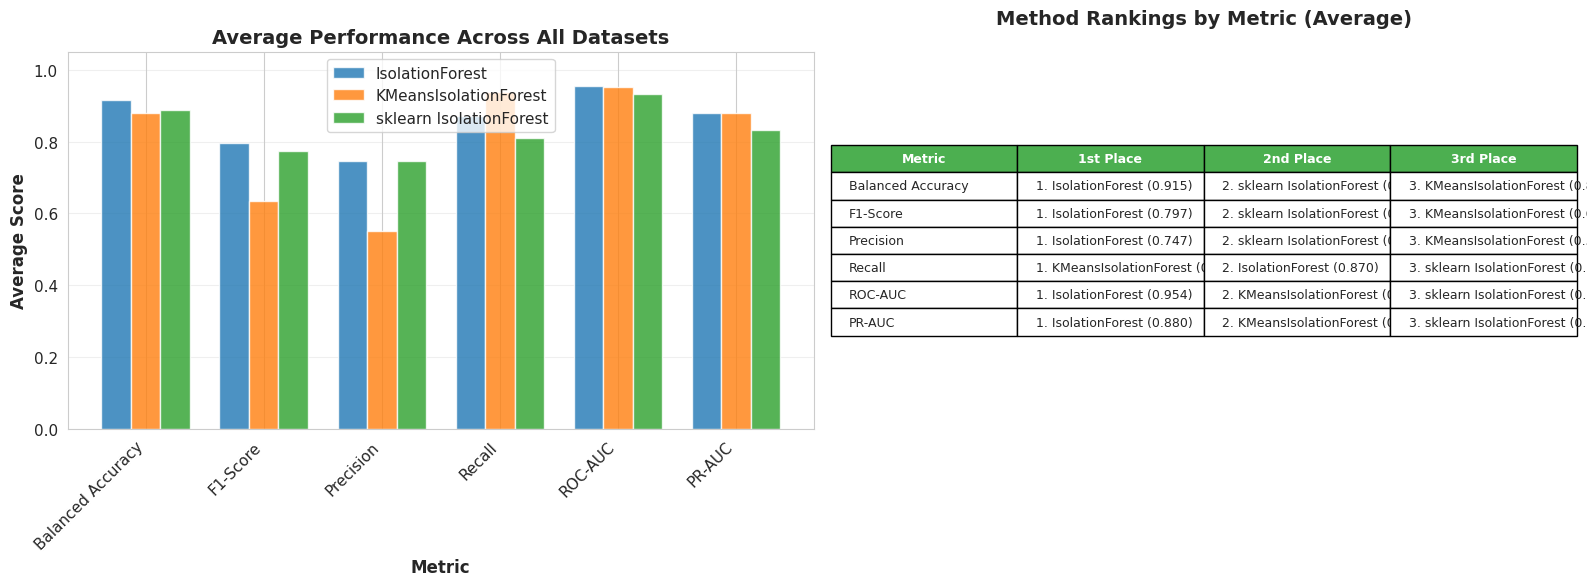

Accuracy summary plot saved to results/timing/accuracy_summary.png ✅


In [23]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

mean_performance = df_accuracy.groupby('Method')[metrics].mean()

# Left Plot: Radar chart style (but using grouped bars)
x = np.arange(len(metrics))
width = 0.25

for i, method in enumerate(mean_performance.index):
    offset = width * (i - 1)
    ax1.bar(x + offset, mean_performance.loc[method], width, label=method, alpha=0.8)

ax1.set_xlabel('Metric', fontsize=12, fontweight='bold')
ax1.set_ylabel('Average Score', fontsize=12, fontweight='bold')
ax1.set_title('Average Performance Across All Datasets', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1.05])

# Right Plot: Method ranking table
ax2.axis('off')

# Create ranking table
ranking_data = []
for metric in metrics:
    sorted_methods = df_accuracy.groupby('Method')[metric].mean().sort_values(ascending=False)
    ranking_data.append([
        metric,
        f"1. {sorted_methods.index[0]} ({sorted_methods.iloc[0]:.3f})",
        f"2. {sorted_methods.index[1]} ({sorted_methods.iloc[1]:.3f})",
        f"3. {sorted_methods.index[2]} ({sorted_methods.iloc[2]:.3f})"
    ])

table = ax2.table(cellText=ranking_data, 
                 colLabels=['Metric', '1st Place', '2nd Place', '3rd Place'],
                 cellLoc='left', loc='center',
                 colWidths=[0.25, 0.25, 0.25, 0.25])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Style header
for i in range(4):
    table[(0, i)].set_facecolor('#4CAF50')
    table[(0, i)].set_text_props(weight='bold', color='white')

ax2.set_title('Method Rankings by Metric (Average)', fontsize=14, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('../results/timing/accuracy_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print("Accuracy summary plot saved to results/timing/accuracy_summary.png \u2705")

In [22]:
print("-" * 80)
print("STATISTICAL SUMMARY")
print("-" * 80)

print("\nAverage Performance Across All Datasets:")
print("-" * 80)

mean_perf = df_accuracy.groupby('Method')[metrics].mean()

print(mean_perf.to_string())

print("\n\nStandard Deviation Across Datasets:")
print("-" * 80)

std_perf = df_accuracy.groupby('Method')[metrics].std()

print(std_perf.to_string())

print("\n\nBest Method per Metric:")
print("-" * 80)

for metric in metrics:
    best_method = mean_perf[metric].idxmax()
    best_score = mean_perf[metric].max()
    print(f"{metric:<25}: {best_method:<30} (avg: {best_score:.4f})")

print("\n" + "-" * 80)

--------------------------------------------------------------------------------
STATISTICAL SUMMARY
--------------------------------------------------------------------------------

Average Performance Across All Datasets:
--------------------------------------------------------------------------------
                         Balanced Accuracy  F1-Score  Precision  Recall   ROC-AUC    PR-AUC
Method                                                                                     
IsolationForest                   0.914944  0.797399   0.747258   0.870  0.954444  0.879899
KMeansIsolationForest             0.878333  0.636062   0.552066   0.939  0.950999  0.879629
sklearn IsolationForest           0.888278  0.774814   0.747245   0.810  0.931556  0.832487


Standard Deviation Across Datasets:
--------------------------------------------------------------------------------
                         Balanced Accuracy  F1-Score  Precision    Recall   ROC-AUC    PR-AUC
Method                